In [25]:
# EfficientNet-B0 com 4 Configurações por 40 epochs

In [26]:
!pip install efficientnet-pytorch

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
from tqdm import tqdm
import time
from sklearn.metrics import f1_score, accuracy_score, cohen_kappa_score, hamming_loss, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
import json

In [27]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import seaborn as sns
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Dispositivo: {device}")

# ==================== PATHS CORRETOS ====================

# Base do dataset
DATASET_BASE = "/kaggle/input/odir5k"
DATASET_ROOT = "/kaggle/input/odir5k/data/odir5k"

# Paths das splits
TRAIN_DIR = f"{DATASET_ROOT}/train"
VAL_DIR = f"{DATASET_ROOT}/val"
TEST_DIR = f"{DATASET_ROOT}/test"

# Output
MODEL_SAVE_PATH = "/kaggle/working"
CURRENT_DIR = "/kaggle/working"
      
class ODIRDataset(Dataset):
    """Dataset ODIR-5K usando estrutura de pastas"""
    
    def __init__(self, split='train', transform=None):
        self.split = split
        self.transform = transform
        self.img_dir = os.path.join(DATASET_ROOT, split)
        
        # Carregar metadados
        metadata_path = os.path.join(self.img_dir, f"{split}_metadata.csv")
        self.data = pd.read_csv(metadata_path)
        self.disease_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
        self.image_files = [f for f in os.listdir(self.img_dir) if f.endswith('.jpg')]
        
        print(f"  📂 {split}: {len(self.data)} pacients, {len(self.image_files)} images")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        patient_id = str(row['ID'])
        
        img_path = None
        for side in ['left', 'right']:
            img_name = f"{patient_id}_{side}.jpg"
            full_path = os.path.join(self.img_dir, img_name)
            if os.path.exists(full_path):
                img_path = full_path
                break
        
        if img_path is None:
            raise FileNotFoundError(f"Imagem não encontrada para ID {patient_id}")
        
        image = Image.open(img_path).convert('RGB')
        labels = torch.tensor([row[col] for col in self.disease_cols], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, labels, patient_id

class CropOnly(object):
        """Só cropping, SEM CLAHE"""
        
        def __call__(self, img):
            img = np.array(img)
            
            # Mesmo cropping que ApplyCLAHEandCrop_Adaptive mas SEM CLAHE
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            mask = gray > 10
            if np.any(mask):
                coords = np.argwhere(mask)
                y0, x0 = coords.min(axis=0)
                y1, x1 = coords.max(axis=0) + 1
                img = img[y0:y1, x0:x1]
            
            return Image.fromarray(img)
class ApplyCLAHEandCrop_Adaptive(object):
    """
    CLAHE adaptativo: só aplica em imagens de baixo contraste
    """
    
    def __init__(self):
        self.contrast_threshold = 50   # ← OTIMIZADO!
        self.clip_limit = 3.0          # Suave
        self.tile_grid_size = (8, 8)
    
    def __call__(self, img):
        # To numpy (opencv)
        img = np.array(img)
        
        # ==================== CROPPING ====================
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray > 10
        
        if np.any(mask):
            coords = np.argwhere(mask)
            y0, x0 = coords.min(axis=0)
            y1, x1 = coords.max(axis=0) + 1
            img = img[y0:y1, x0:x1]
        
        # ==================== MEDIR CONTRASTE ====================
        gray_cropped = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        contrast = gray_cropped.std()  # Standard deviation = contraste
        
        # ==================== CLAHE ADAPTATIVO ====================
        # SÓ aplicar se contraste baixo!
        if contrast < self.contrast_threshold:
            # Converter para LAB
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            
            # Aplicar CLAHE no canal L
            clahe = cv2.createCLAHE(
                clipLimit=self.clip_limit,
                tileGridSize=self.tile_grid_size
            )
            l = clahe.apply(l)
            
            # Merge e converter de volta
            img = cv2.merge([l, a, b])
            img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
        
        # To PIL
        return Image.fromarray(img)

def get_train_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_train_transform_CLAHE():
    return transforms.Compose([
        ApplyCLAHEandCrop_Adaptive(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_val_test_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_val_test_transform_CLAHE():
    return transforms.Compose([
        ApplyCLAHEandCrop_Adaptive(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
        
def get_v1_baseline_transform():
    """V1: Baseline puro (SEM crop, SEM aug, SEM CLAHE)"""
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])


def get_v2_crop_only_transform():
    """V2: Só cropping (SEM aug, SEM CLAHE)"""
    return transforms.Compose([
        CropOnly(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])


def get_v3_crop_aug_transform():
    """V3: Cropping + Augmentation (SEM CLAHE)"""
    return transforms.Compose([
        CropOnly(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])


def get_v4_full_pipeline_transform():
    """V4: Full Pipeline (Crop + Aug + CLAHE)"""
    return transforms.Compose([
        ApplyCLAHEandCrop_Adaptive(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
# --- Verificação de Segurança e Execução ---
if not os.path.exists(DATASET_ROOT):
    print(f"❌ ERRO: Dataset não encontrado em {DATASET_ROOT}")
else:
    # 1. Criar Datasets Reais
    train_dataset_basic = ODIRDataset('train', transform=get_train_transform())
    train_dataset_clahe = ODIRDataset('train', transform=get_train_transform_CLAHE())
    
    val_dataset = ODIRDataset('val', transform=get_val_test_transform_CLAHE())
    test_dataset = ODIRDataset('test', transform=get_val_test_transform_CLAHE())
    
    print("\n Resume: Train:", len(train_dataset_clahe), "| Val:", len(val_dataset), "| Test:", len(test_dataset))

def create_datasets_for_config(config_name):
    """
    Criar train/val/test datasets para uma configuração
    
    Args:
        config_name: 'v1', 'v2', 'v3', ou 'v4'
    
    Returns:
        dict com keys 'train', 'val', 'test'
    """
    
    train_transforms = {
        'v1': get_v1_baseline_transform(),
        'v2': get_v2_crop_only_transform(),
        'v3': get_v3_crop_aug_transform(),
        'v4': get_v4_full_pipeline_transform()
    }
    
    val_test_transforms = {
        'v1': get_val_test_transform(),
        'v2': get_val_test_transform(),
        'v3': get_val_test_transform(),
        'v4': get_val_test_transform_CLAHE()
    }
    
    print(f"\n📦 Criando datasets para config: {config_name.upper()}")
    
    datasets = {
        'train': ODIRDataset('train', transform=train_transforms[config_name]),
        'val': ODIRDataset('val', transform=val_test_transforms[config_name]),
        'test': ODIRDataset('test', transform=val_test_transforms[config_name])
    }
    
    print(f"✅ Datasets {config_name} criados!")
    
    return datasets

Looking in indexes: https://download.pytorch.org/whl/cpu
🚀 Dispositivo: cuda
  📂 train: 4474 pacients, 5732 images
  📂 train: 4474 pacients, 5732 images
  📂 val: 959 pacients, 1728 images
  📂 test: 959 pacients, 1748 images

 Resume: Train: 4474 | Val: 959 | Test: 959


In [28]:
datasets_v1 = create_datasets_for_config('v1')
datasets_v2 = create_datasets_for_config('v2')
datasets_v3 = create_datasets_for_config('v3')
datasets_v4 = create_datasets_for_config('v4')


📦 Criando datasets para config: V1
  📂 train: 4474 pacients, 5732 images
  📂 val: 959 pacients, 1728 images
  📂 test: 959 pacients, 1748 images
✅ Datasets v1 criados!

📦 Criando datasets para config: V2
  📂 train: 4474 pacients, 5732 images
  📂 val: 959 pacients, 1728 images
  📂 test: 959 pacients, 1748 images
✅ Datasets v2 criados!

📦 Criando datasets para config: V3
  📂 train: 4474 pacients, 5732 images
  📂 val: 959 pacients, 1728 images
  📂 test: 959 pacients, 1748 images
✅ Datasets v3 criados!

📦 Criando datasets para config: V4
  📂 train: 4474 pacients, 5732 images
  📂 val: 959 pacients, 1728 images
  📂 test: 959 pacients, 1748 images
✅ Datasets v4 criados!


In [29]:
train_v1 = datasets_v1['train']
val_v1 = datasets_v1['val']
test_v1 = datasets_v1['test']

train_v2 = datasets_v2['train']
val_v2 = datasets_v2['val']
test_v2 = datasets_v2['test']

train_v3 = datasets_v3['train']
val_v3 = datasets_v3['val']
test_v3 = datasets_v3['test']

train_v4 = datasets_v4['train']
val_v4 = datasets_v4['val']
test_v4 = datasets_v4['test']

In [30]:
!pip install timm
import timm
class EfficientNetB0MultiLabel(nn.Module):
    def __init__(self, num_classes=8, dropout=0.2):
        super().__init__()
        
        # timm é mais moderno e melhor
        self.model = timm.create_model(
            'efficientnet_b0',
            pretrained=True,
            drop_rate=dropout, 
            num_classes=num_classes
        )
    
    def forward(self, x):
        return self.model(x)

In [31]:
def calculate_class_weights_clipped(dataset, max_weight=3.0):
    """
    Calcular SQRT weights + CLIP em valor máximo
    """
    import numpy as np
    from tqdm import tqdm
    
    print(f"\n📊 Calculating CLIPPED class weights (max={max_weight})...")
    
    labels = []
    for _, label, _ in tqdm(dataset, desc='Scanning'):
        labels.append(label.numpy())
    
    labels = np.array(labels)
    pos_counts = labels.sum(axis=0)
    neg_counts = len(labels) - pos_counts
    
    # SQRT
    weights_raw = neg_counts / (pos_counts + 1e-6)
    weights_sqrt = np.sqrt(weights_raw)
    
    # CLIP!
    weights_clipped = np.clip(weights_sqrt, 1.0, max_weight)
    
    # Mostrar
    class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    print(f"\n{'Class':<8} {'Pos':<8} {'Sqrt':<8} {'Clipped':<10} {'Change':<12}")
    print("-" * 55)
    for name, w_sqrt, w_clip, pos in zip(class_names, weights_sqrt, weights_clipped, pos_counts):
        change = "" if abs(w_sqrt - w_clip) < 0.01 else f"✂️ {w_sqrt:.2f}→{w_clip:.2f}"
        print(f"{name:<8} {int(pos):<8} {w_sqrt:.2f}   {w_clip:.2f}      {change}")
    print("-" * 55)
    
    clipped_count = sum(weights_sqrt > max_weight)
    print(f"✅ Weights clipped: {clipped_count} classes")
    print(f"   Max weight: {max_weight}")
    print(f"   Range: {weights_clipped.min():.2f} - {weights_clipped.max():.2f}\n")
    
    return torch.tensor(weights_clipped, dtype=torch.float)

In [32]:
class FocalLoss(nn.Module):
    """
    Focal Loss para multi-label classification
    
    Foca em exemplos difíceis sem forçar agressividade em classes raras
    
    Args:
        alpha (float): Balanceamento positivo/negativo (default: 0.25)
        gamma (float): Focusing parameter (default: 2.0)
            - gamma=0: equivale a BCE
            - gamma=2: foco moderado em difíceis (RECOMENDADO)
            - gamma=5: foco forte em difíceis
    """
    
    def __init__(self, alpha=0.25, gamma=3.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        """
        Args:
            inputs: logits (before sigmoid), shape [batch, num_classes]
            targets: ground truth labels, shape [batch, num_classes]
        """
        # BCE loss
        bce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        
        # Probabilidades
        probs = torch.sigmoid(inputs)
        
        # p_t: probabilidade da classe correta
        # Se target=1: p_t = prob
        # Se target=0: p_t = 1-prob
        p_t = probs * targets + (1 - probs) * (1 - targets)
        
        # Focal term: (1 - p_t)^gamma
        # Exemplos fáceis (p_t alto) → peso baixo
        # Exemplos difíceis (p_t baixo) → peso alto
        focal_weight = (1 - p_t) ** self.gamma
        
        # Alpha balancing
        # targets=1 → alpha
        # targets=0 → 1-alpha
        alpha_weight = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        
        # Focal loss final
        focal_loss = alpha_weight * focal_weight * bce_loss
        
        return focal_loss.mean()


In [33]:
def optimize_thresholds(model, val_loader, device):
    """
    Otimizar threshold por classe no validation set
    EXECUTAR DEPOIS do treino!
    """
    import numpy as np
    from tqdm import tqdm
    from sklearn.metrics import f1_score
    
    print("\n" + "="*70)
    print("🔍 OPTIMIZING THRESHOLDS")
    print("="*70)
    
    model.eval()
    
    # Coletar todas as predições
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, _ in tqdm(val_loader, desc='Collecting predictions'):
            images = images.to(device)
            outputs = torch.sigmoid(model(images))
            all_probs.append(outputs.cpu())
            all_labels.append(labels)
    
    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    # Otimizar threshold para cada classe
    optimal_thresholds = []
    class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    
    print(f"\n{'Class':<8} {'Default F1':<12} {'Best F1':<12} {'Threshold':<12} {'Gain':<10}")
    print("-" * 60)
    
    total_gain = 0
    
    for i in range(8):
        # F1 com threshold default 0.5
        default_preds = (all_probs[:, i] > 0.5).astype(int)
        default_f1 = f1_score(all_labels[:, i], default_preds, zero_division=0)
        
        # Buscar melhor threshold
        best_f1 = 0
        best_thresh = 0.5
        
        for thresh in np.arange(0.05, 0.95, 0.02):
            preds = (all_probs[:, i] > thresh).astype(int)
            f1 = f1_score(all_labels[:, i], preds, zero_division=0)
            
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        
        optimal_thresholds.append(best_thresh)
        gain = best_f1 - default_f1
        total_gain += gain
        
        print(f"{class_names[i]:<8} {default_f1:.4f}       {best_f1:.4f}       "
              f"{best_thresh:.2f}          {gain:+.4f}")
    
    print("-" * 60)
    print(f"Average gain: {total_gain/8:+.4f}\n")
    
    return np.array(optimal_thresholds)

In [34]:
def evaluate_with_thresholds(model, test_loader, thresholds, device):
    """
    Avaliar test set com thresholds otimizados
    """
    from sklearn.metrics import f1_score, hamming_loss
    
    model.eval()
    
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        for images, labels, _ in tqdm(test_loader, desc='Testing with optimized thresholds'):
            images = images.to(device)
            outputs = torch.sigmoid(model(images)).cpu().numpy()
            
            # Aplicar threshold específico por classe
            preds = np.zeros_like(outputs)
            for i in range(8):
                preds[:, i] = (outputs[:, i] > thresholds[i]).astype(int)
            
            test_preds.append(preds)
            test_labels.append(labels.numpy())
    
    test_preds = np.concatenate(test_preds)
    test_labels = np.concatenate(test_labels)
    
    # Métricas
    test_f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)
    test_acc = 1.0 - hamming_loss(test_labels, test_preds)
    per_class_f1 = f1_score(test_labels, test_preds, average=None, zero_division=0)
    
    return test_f1, test_acc, per_class_f1

In [35]:
def train_model_complete(train_dataset, val_dataset, test_dataset, 
                        config_name, num_epochs=10, batch_size=32, lr=1e-4, use_class_weights=False, use_focal_loss=False):
    """
    Treinar EfficientNet com visualizações automáticas para o relatório
    """
    
    print(f"\n{'='*70}")
    print(f"TRAINING EFFICIENTNET-B0 - {config_name.upper()}")
    print(f"{'='*70}\n")
    
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pin= True
    print(f"\n🚀 Device: {device}")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=2, pin_memory=pin)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size,
                              shuffle=False, num_workers=2, pin_memory=pin)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size,
                              shuffle=False, num_workers=2, pin_memory=pin)

    # Model
    model = EfficientNetB0MultiLabel(num_classes=8, dropout=0.2)
    model = model.to(device)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"📊 Model: {num_params:,} parameters")

    # ==================== LOSS COM CLASS WEIGHTS ====================
    if use_class_weights:
        print("\n🔧 Using CLIPPED CLASS WEIGHTS to balance classes...")
        class_weights = calculate_class_weights_clipped(  # ← USAR FUNÇÃO NOVA!
            train_dataset, 
            max_weight=3.0  # ← H será 2.38 (não 5.65!)
        ).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
        print("✅ Clipped class weights activated!")
    else:
        criterion = nn.BCEWithLogitsLoss()
        print("⚠️  Using standard BCE (no class weights)")

    criterion = criterion.to(device)
    
    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr,           
        weight_decay=1e-4  
    )    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5
    )
    
    # Tracking
    history = {
        'train_loss': [], 'train_f1': [], 'train_acc': [],
        'val_loss': [], 'val_f1': [], 'val_acc': [],
        'learning_rates': [], 'epoch_times': []
    }
    
    best_val_f1 = 0.0
    start_time = time.time()
    
    # ==================== TRAINING LOOP ====================
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # TRAIN
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []
        
        for images, labels, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_preds.append(torch.sigmoid(outputs).detach().cpu())
            train_labels.append(labels.cpu())
        
        train_loss /= len(train_loader)
        train_preds = torch.cat(train_preds).numpy()
        train_labels = torch.cat(train_labels).numpy()
        train_preds_binary = (train_preds > 0.5).astype(int)
        
        train_f1 = f1_score(train_labels, train_preds_binary, average='macro', zero_division=0)
        train_acc = 1.0 - hamming_loss(train_labels, train_preds_binary)
        
        # VALIDATION
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        
        with torch.no_grad():
            for images, labels, _ in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                val_preds.append(torch.sigmoid(outputs).cpu())
                val_labels.append(labels.cpu())
        
        val_loss /= len(val_loader)
        val_preds = torch.cat(val_preds).numpy()
        val_labels = torch.cat(val_labels).numpy()
        val_preds_binary = (val_preds > 0.5).astype(int)
        
        val_f1 = f1_score(val_labels, val_preds_binary, average='macro', zero_division=0)
        val_acc   = 1.0 - hamming_loss(val_labels, val_preds_binary)
        
        # Scheduler
        scheduler.step(val_f1)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        epoch_time = time.time() - epoch_start
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(current_lr)
        history['epoch_times'].append(epoch_time)
        
        # Print progress
        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"  Train - Loss: {train_loss:.4f}, F1: {train_f1:.4f}, Acc: {train_acc:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, F1: {val_f1:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.2e}, Time: {epoch_time:.1f}s")
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1,
                'history': history
            }, f'efficientnet_{config_name}_best.pth')
            print(f"  ✅ Best model saved! (F1: {val_f1:.4f})")
    
    total_train_time = time.time() - start_time
    
    # ==================== TEST EVALUATION ====================
    print(f"\n{'='*70}")
    print("EVALUATING ON TEST SET")
    print(f"{'='*70}\n")
    
    checkpoint = torch.load(f'efficientnet_{config_name}_best.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    test_preds, test_labels = [], []
    inference_times = []
    
    with torch.no_grad():
        for images, labels, _ in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            
            start = time.time()
            outputs = model(images)
            inference_times.append((time.time() - start) / len(images))
            
            test_preds.append(torch.sigmoid(outputs).cpu())
            test_labels.append(labels.cpu())
    
    test_preds = torch.cat(test_preds).numpy()
    test_labels = torch.cat(test_labels).numpy()
    test_preds_binary = (test_preds > 0.5).astype(int)
    
    # Metrics
    test_f1 = f1_score(test_labels, test_preds_binary, average='macro', zero_division=0)
    test_acc  = 1.0 - hamming_loss(test_labels, test_preds_binary)
    kappas = [
        cohen_kappa_score(test_labels[:, i], test_preds_binary[:, i])
        for i in range(test_labels.shape[1])
    ]
    test_kappa = float(np.mean(kappas))
    
    # Per-class metrics
    class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    per_class_f1 = f1_score(test_labels, test_preds_binary, average=None, zero_division=0)
    
    print(f"\n📊 FINAL TEST RESULTS - {config_name.upper()}:")
    print(f"  Accuracy:  {test_acc:.4f}")
    print(f"  F1-Score:  {test_f1:.4f}")
    print(f"  Kappa:     {test_kappa:.4f}")
    print(f"  Avg Epoch Time: {np.mean(history['epoch_times']):.1f}s")
    print(f"  Avg Inference:  {np.mean(inference_times)*1000:.2f}ms/image")
    print(f"\n  Per-class F1:")
    for i, name in enumerate(class_names):
        print(f"    {name}: {per_class_f1[i]:.4f}")
    
    # ==================== SAVE RESULTS ====================
    results = {
        'config': config_name,
        'num_params': num_params,
        'num_epochs': num_epochs,
        'best_val_f1': float(best_val_f1),
        'test_accuracy': float(test_acc),
        'test_f1': float(test_f1),
        'test_kappa': float(test_kappa),
        'per_class_f1': {name: float(f1) for name, f1 in zip(class_names, per_class_f1)},
        'total_train_time': float(total_train_time),
        'avg_epoch_time': float(np.mean(history['epoch_times'])),
        'avg_inference_time_ms': float(np.mean(inference_times) * 1000)
    }
    
    with open(f'efficientnet_{config_name}_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    # Save history
    np.save(f'efficientnet_{config_name}_history.npy', history)
    
    # ==================== GENERATE VISUALIZATIONS ====================
    print(f"\n📊 Generating visualizations for report...")
    
    # 1. TRAINING CURVES
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'EfficientNet-B0 {config_name.upper()} - Training Progress', 
                 fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # F1-Score
    axes[0, 1].plot(epochs, history['train_f1'], 'b-', label='Train F1', linewidth=2)
    axes[0, 1].plot(epochs, history['val_f1'], 'r-', label='Val F1', linewidth=2)
    axes[0, 1].axhline(y=best_val_f1, color='g', linestyle='--', 
                       label=f'Best Val F1: {best_val_f1:.4f}')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('F1-Score')
    axes[0, 1].set_title('F1-Score Progress')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Accuracy
    axes[1, 0].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[1, 0].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Accuracy Progress')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Learning Rate
    axes[1, 1].plot(epochs, history['learning_rates'], 'purple', linewidth=2)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'efficientnet_{config_name}_training_curves.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. CONFUSION MATRIX (multi-label)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'{config_name.upper()} - Per-Class Confusion Matrices', 
                 fontsize=16, fontweight='bold')
    
    for i, class_name in enumerate(class_names):
        ax = axes[i // 4, i % 4]
        cm = confusion_matrix(test_labels[:, i], test_preds_binary[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                   xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
        ax.set_title(f'{class_name} (F1: {per_class_f1[i]:.3f})')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    
    plt.tight_layout()
    plt.savefig(f'efficientnet_{config_name}_confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. PER-CLASS F1 BAR CHART
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(class_names, per_class_f1, color='steelblue', edgecolor='black')
    ax.axhline(y=test_f1, color='red', linestyle='--', linewidth=2, 
               label=f'Average F1: {test_f1:.4f}')
    ax.set_xlabel('Disease Class', fontsize=12)
    ax.set_ylabel('F1-Score', fontsize=12)
    ax.set_title(f'{config_name.upper()} - Per-Class Performance', 
                 fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1.0])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, f1 in zip(bars, per_class_f1):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{f1:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'efficientnet_{config_name}_per_class_f1.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"✅ Visualizations saved:")
    print(f"   - efficientnet_{config_name}_training_curves.png")
    print(f"   - efficientnet_{config_name}_confusion_matrices.png")
    print(f"   - efficientnet_{config_name}_per_class_f1.png")
    print(f"   - efficientnet_{config_name}_results.json")
    print(f"   - efficientnet_{config_name}_history.npy")
    
    return results, model, history

print("✅ Training function with visualizations ready!")

✅ Training function with visualizations ready!


In [36]:
def get_v4_optimized_transform():
    return transforms.Compose([
        ApplyCLAHEandCrop_Adaptive(),  # ← CLAHE!
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),
        transforms.ColorJitter(brightness=0.1, contrast=0.0),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

def get_v4_val_transform():
    return transforms.Compose([
        ApplyCLAHEandCrop_Adaptive(),  # ← CLAHE!
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
        
# V1: Baseline
print("\n" + "="*70)
print("🔵 CONFIGURATION V1: BASELINE")
print("="*70)
results_v1, model_v1, history_v1 = train_model_complete(
    train_v1, val_v1, test_v1, 'v1', num_epochs=40, batch_size=32, lr=1e-4
)

# V2: Baseline + Cropping
print("\n" + "="*70)
print("🟢 CONFIGURATION V2: BASELINE + CROPPING")
print("="*70)
results_v2, model_v2, history_v2 = train_model_complete(
    train_v2, val_v2, test_v2, 'v2', num_epochs=40, batch_size=32, lr=1e-4
)

# V3: Cropping + Augmentation
print("\n" + "="*70)
print("🟡 CONFIGURATION V3: CROPPING + AUGMENTATION")
print("="*70)
results_v3, model_v3, history_v3 = train_model_complete(
    train_v3, val_v3, test_v3, 'v3', num_epochs=40, batch_size=32, lr=1e-4
)

# V4: Full Pipeline (CLAHE)
print("\n" + "="*70)
print("🔴 CONFIGURATION V4: FULL PIPELINE")
print("="*70)
results_v4, model_v4, history_v4 = train_model_complete(
    train_v4, val_v4, test_v4, 'v4', num_epochs=40, batch_size=32, lr=1e-4
)

print("\n" + "="*70)
print("✅ ALL CONFIGURATIONS TRAINED SUCCESSFULLY!")
print("="*70)


🔵 CONFIGURATION V1: BASELINE

TRAINING EFFICIENTNET-B0 - V1


🚀 Device: cuda
📊 Model: 4,017,796 parameters
⚠️  Using standard BCE (no class weights)


Epoch 1/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  7.56it/s]



Epoch 1/40:
  Train - Loss: 0.4493, F1: 0.2859, Acc: 0.8134
  Val   - Loss: 0.2836, F1: 0.4326, Acc: 0.8745
  LR: 1.00e-04, Time: 27.2s
  ✅ Best model saved! (F1: 0.4326)


Epoch 2/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.71it/s]



Epoch 2/40:
  Train - Loss: 0.2348, F1: 0.5627, Acc: 0.8984
  Val   - Loss: 0.2170, F1: 0.6275, Acc: 0.9085
  LR: 1.00e-04, Time: 26.9s
  ✅ Best model saved! (F1: 0.6275)


Epoch 3/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]



Epoch 3/40:
  Train - Loss: 0.1562, F1: 0.7425, Acc: 0.9381
  Val   - Loss: 0.1852, F1: 0.7166, Acc: 0.9312
  LR: 1.00e-04, Time: 26.3s
  ✅ Best model saved! (F1: 0.7166)


Epoch 4/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.21it/s]



Epoch 4/40:
  Train - Loss: 0.1015, F1: 0.8500, Acc: 0.9636
  Val   - Loss: 0.1675, F1: 0.7964, Acc: 0.9420
  LR: 1.00e-04, Time: 26.7s
  ✅ Best model saved! (F1: 0.7964)


Epoch 5/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]



Epoch 5/40:
  Train - Loss: 0.0700, F1: 0.9074, Acc: 0.9770
  Val   - Loss: 0.1537, F1: 0.8224, Acc: 0.9496
  LR: 1.00e-04, Time: 26.6s
  ✅ Best model saved! (F1: 0.8224)


Epoch 6/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.75it/s]



Epoch 6/40:
  Train - Loss: 0.0458, F1: 0.9493, Acc: 0.9871
  Val   - Loss: 0.1543, F1: 0.8265, Acc: 0.9498
  LR: 1.00e-04, Time: 26.4s
  ✅ Best model saved! (F1: 0.8265)


Epoch 7/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]



Epoch 7/40:
  Train - Loss: 0.0322, F1: 0.9696, Acc: 0.9916
  Val   - Loss: 0.1660, F1: 0.8238, Acc: 0.9480
  LR: 1.00e-04, Time: 26.6s


Epoch 8/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.40it/s]



Epoch 8/40:
  Train - Loss: 0.0215, F1: 0.9840, Acc: 0.9957
  Val   - Loss: 0.1688, F1: 0.8281, Acc: 0.9507
  LR: 1.00e-04, Time: 26.6s
  ✅ Best model saved! (F1: 0.8281)


Epoch 9/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.78it/s]



Epoch 9/40:
  Train - Loss: 0.0190, F1: 0.9889, Acc: 0.9962
  Val   - Loss: 0.1823, F1: 0.8413, Acc: 0.9542
  LR: 1.00e-04, Time: 26.4s
  ✅ Best model saved! (F1: 0.8413)


Epoch 10/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.54it/s]



Epoch 10/40:
  Train - Loss: 0.0140, F1: 0.9893, Acc: 0.9972
  Val   - Loss: 0.1785, F1: 0.8468, Acc: 0.9535
  LR: 1.00e-04, Time: 26.6s
  ✅ Best model saved! (F1: 0.8468)


Epoch 11/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.78it/s]



Epoch 11/40:
  Train - Loss: 0.0144, F1: 0.9879, Acc: 0.9961
  Val   - Loss: 0.1864, F1: 0.8409, Acc: 0.9514
  LR: 1.00e-04, Time: 26.4s


Epoch 12/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.51it/s]



Epoch 12/40:
  Train - Loss: 0.0116, F1: 0.9903, Acc: 0.9971
  Val   - Loss: 0.1900, F1: 0.8331, Acc: 0.9527
  LR: 1.00e-04, Time: 26.5s


Epoch 13/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.55it/s]



Epoch 13/40:
  Train - Loss: 0.0110, F1: 0.9944, Acc: 0.9976
  Val   - Loss: 0.1891, F1: 0.8461, Acc: 0.9559
  LR: 1.00e-04, Time: 26.6s


Epoch 14/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.41it/s]



Epoch 14/40:
  Train - Loss: 0.0086, F1: 0.9945, Acc: 0.9984
  Val   - Loss: 0.1958, F1: 0.8465, Acc: 0.9550
  LR: 1.00e-04, Time: 26.6s


Epoch 15/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]



Epoch 15/40:
  Train - Loss: 0.0083, F1: 0.9936, Acc: 0.9979
  Val   - Loss: 0.1989, F1: 0.8453, Acc: 0.9544
  LR: 1.00e-04, Time: 26.5s


Epoch 16/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.58it/s]



Epoch 16/40:
  Train - Loss: 0.0075, F1: 0.9954, Acc: 0.9985
  Val   - Loss: 0.2073, F1: 0.8296, Acc: 0.9506
  LR: 5.00e-05, Time: 26.6s


Epoch 17/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.50it/s]



Epoch 17/40:
  Train - Loss: 0.0054, F1: 0.9972, Acc: 0.9988
  Val   - Loss: 0.2047, F1: 0.8373, Acc: 0.9519
  LR: 5.00e-05, Time: 26.6s


Epoch 18/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.72it/s]



Epoch 18/40:
  Train - Loss: 0.0040, F1: 0.9980, Acc: 0.9992
  Val   - Loss: 0.2192, F1: 0.8381, Acc: 0.9526
  LR: 5.00e-05, Time: 26.5s


Epoch 19/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.33it/s]



Epoch 19/40:
  Train - Loss: 0.0043, F1: 0.9979, Acc: 0.9991
  Val   - Loss: 0.2125, F1: 0.8475, Acc: 0.9549
  LR: 5.00e-05, Time: 26.6s
  ✅ Best model saved! (F1: 0.8475)


Epoch 20/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.45it/s]



Epoch 20/40:
  Train - Loss: 0.0034, F1: 0.9987, Acc: 0.9996
  Val   - Loss: 0.2160, F1: 0.8431, Acc: 0.9529
  LR: 5.00e-05, Time: 26.6s


Epoch 21/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.75it/s]



Epoch 21/40:
  Train - Loss: 0.0035, F1: 0.9981, Acc: 0.9993
  Val   - Loss: 0.2144, F1: 0.8439, Acc: 0.9533
  LR: 5.00e-05, Time: 26.4s


Epoch 22/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.71it/s]



Epoch 22/40:
  Train - Loss: 0.0022, F1: 0.9995, Acc: 0.9998
  Val   - Loss: 0.2136, F1: 0.8465, Acc: 0.9535
  LR: 5.00e-05, Time: 26.5s


Epoch 23/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.53it/s]



Epoch 23/40:
  Train - Loss: 0.0025, F1: 0.9988, Acc: 0.9996
  Val   - Loss: 0.2179, F1: 0.8372, Acc: 0.9527
  LR: 5.00e-05, Time: 26.6s


Epoch 24/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.53it/s]



Epoch 24/40:
  Train - Loss: 0.0020, F1: 0.9996, Acc: 0.9997
  Val   - Loss: 0.2278, F1: 0.8420, Acc: 0.9527
  LR: 5.00e-05, Time: 26.6s


Epoch 25/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]



Epoch 25/40:
  Train - Loss: 0.0038, F1: 0.9985, Acc: 0.9991
  Val   - Loss: 0.2160, F1: 0.8471, Acc: 0.9553
  LR: 2.50e-05, Time: 26.6s


Epoch 26/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]



Epoch 26/40:
  Train - Loss: 0.0026, F1: 0.9991, Acc: 0.9997
  Val   - Loss: 0.2199, F1: 0.8456, Acc: 0.9541
  LR: 2.50e-05, Time: 26.5s


Epoch 27/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.60it/s]



Epoch 27/40:
  Train - Loss: 0.0025, F1: 0.9986, Acc: 0.9996
  Val   - Loss: 0.2183, F1: 0.8490, Acc: 0.9557
  LR: 2.50e-05, Time: 26.5s
  ✅ Best model saved! (F1: 0.8490)


Epoch 28/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.71it/s]



Epoch 28/40:
  Train - Loss: 0.0016, F1: 0.9995, Acc: 0.9998
  Val   - Loss: 0.2206, F1: 0.8488, Acc: 0.9558
  LR: 2.50e-05, Time: 26.5s


Epoch 29/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.46it/s]



Epoch 29/40:
  Train - Loss: 0.0018, F1: 0.9996, Acc: 0.9997
  Val   - Loss: 0.2259, F1: 0.8420, Acc: 0.9523
  LR: 2.50e-05, Time: 26.6s


Epoch 30/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.59it/s]



Epoch 30/40:
  Train - Loss: 0.0014, F1: 0.9998, Acc: 0.9999
  Val   - Loss: 0.2218, F1: 0.8492, Acc: 0.9554
  LR: 2.50e-05, Time: 26.5s
  ✅ Best model saved! (F1: 0.8492)


Epoch 31/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.45it/s]



Epoch 31/40:
  Train - Loss: 0.0014, F1: 0.9997, Acc: 0.9998
  Val   - Loss: 0.2216, F1: 0.8473, Acc: 0.9552
  LR: 2.50e-05, Time: 26.6s


Epoch 32/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]



Epoch 32/40:
  Train - Loss: 0.0013, F1: 0.9995, Acc: 0.9998
  Val   - Loss: 0.2170, F1: 0.8473, Acc: 0.9542
  LR: 2.50e-05, Time: 26.6s


Epoch 33/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.47it/s]



Epoch 33/40:
  Train - Loss: 0.0012, F1: 0.9996, Acc: 0.9999
  Val   - Loss: 0.2250, F1: 0.8454, Acc: 0.9544
  LR: 2.50e-05, Time: 26.6s


Epoch 34/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.56it/s]



Epoch 34/40:
  Train - Loss: 0.0011, F1: 0.9998, Acc: 0.9999
  Val   - Loss: 0.2238, F1: 0.8486, Acc: 0.9548
  LR: 2.50e-05, Time: 26.6s


Epoch 35/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.35it/s]



Epoch 35/40:
  Train - Loss: 0.0011, F1: 0.9998, Acc: 0.9999
  Val   - Loss: 0.2320, F1: 0.8455, Acc: 0.9541
  LR: 2.50e-05, Time: 26.6s


Epoch 36/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.49it/s]



Epoch 36/40:
  Train - Loss: 0.0014, F1: 0.9994, Acc: 0.9997
  Val   - Loss: 0.2382, F1: 0.8443, Acc: 0.9526
  LR: 1.25e-05, Time: 26.5s


Epoch 37/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.05it/s]



Epoch 37/40:
  Train - Loss: 0.0013, F1: 0.9998, Acc: 0.9999
  Val   - Loss: 0.2288, F1: 0.8491, Acc: 0.9549
  LR: 1.25e-05, Time: 26.8s


Epoch 38/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.54it/s]



Epoch 38/40:
  Train - Loss: 0.0010, F1: 0.9996, Acc: 0.9999
  Val   - Loss: 0.2277, F1: 0.8504, Acc: 0.9552
  LR: 1.25e-05, Time: 26.5s
  ✅ Best model saved! (F1: 0.8504)


Epoch 39/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]



Epoch 39/40:
  Train - Loss: 0.0011, F1: 0.9999, Acc: 0.9999
  Val   - Loss: 0.2367, F1: 0.8469, Acc: 0.9542
  LR: 1.25e-05, Time: 26.6s


Epoch 40/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.38it/s]



Epoch 40/40:
  Train - Loss: 0.0008, F1: 0.9999, Acc: 0.9999
  Val   - Loss: 0.2351, F1: 0.8485, Acc: 0.9546
  LR: 1.25e-05, Time: 26.6s

EVALUATING ON TEST SET



Testing: 100%|██████████| 30/30 [00:04<00:00,  7.04it/s]



📊 FINAL TEST RESULTS - V1:
  Accuracy:  0.9541
  F1-Score:  0.8324
  Kappa:     0.8020
  Avg Epoch Time: 26.6s
  Avg Inference:  0.40ms/image

  Per-class F1:
    N: 0.8475
    D: 0.8563
    G: 0.8333
    C: 0.9060
    A: 0.8000
    H: 0.7353
    M: 0.9024
    O: 0.7786

📊 Generating visualizations for report...
✅ Visualizations saved:
   - efficientnet_v1_training_curves.png
   - efficientnet_v1_confusion_matrices.png
   - efficientnet_v1_per_class_f1.png
   - efficientnet_v1_results.json
   - efficientnet_v1_history.npy

🟢 CONFIGURATION V2: BASELINE + CROPPING

TRAINING EFFICIENTNET-B0 - V2


🚀 Device: cuda
📊 Model: 4,017,796 parameters
⚠️  Using standard BCE (no class weights)


Epoch 1/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.44it/s]



Epoch 1/40:
  Train - Loss: 0.4707, F1: 0.2653, Acc: 0.8050
  Val   - Loss: 0.2913, F1: 0.4128, Acc: 0.8741
  LR: 1.00e-04, Time: 41.4s
  ✅ Best model saved! (F1: 0.4128)


Epoch 2/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]



Epoch 2/40:
  Train - Loss: 0.2431, F1: 0.5115, Acc: 0.8963
  Val   - Loss: 0.2418, F1: 0.5618, Acc: 0.8990
  LR: 1.00e-04, Time: 39.6s
  ✅ Best model saved! (F1: 0.5618)


Epoch 3/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.90it/s]



Epoch 3/40:
  Train - Loss: 0.1684, F1: 0.7026, Acc: 0.9321
  Val   - Loss: 0.2084, F1: 0.6369, Acc: 0.9121
  LR: 1.00e-04, Time: 39.8s
  ✅ Best model saved! (F1: 0.6369)


Epoch 4/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.59it/s]



Epoch 4/40:
  Train - Loss: 0.1091, F1: 0.8276, Acc: 0.9610
  Val   - Loss: 0.1803, F1: 0.7292, Acc: 0.9297
  LR: 1.00e-04, Time: 40.0s
  ✅ Best model saved! (F1: 0.7292)


Epoch 5/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.34it/s]



Epoch 5/40:
  Train - Loss: 0.0704, F1: 0.9048, Acc: 0.9778
  Val   - Loss: 0.1664, F1: 0.7883, Acc: 0.9410
  LR: 1.00e-04, Time: 39.3s
  ✅ Best model saved! (F1: 0.7883)


Epoch 6/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.93it/s]



Epoch 6/40:
  Train - Loss: 0.0468, F1: 0.9450, Acc: 0.9866
  Val   - Loss: 0.1634, F1: 0.8069, Acc: 0.9445
  LR: 1.00e-04, Time: 39.5s
  ✅ Best model saved! (F1: 0.8069)


Epoch 7/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.24it/s]



Epoch 7/40:
  Train - Loss: 0.0326, F1: 0.9691, Acc: 0.9918
  Val   - Loss: 0.1648, F1: 0.8283, Acc: 0.9503
  LR: 1.00e-04, Time: 39.9s
  ✅ Best model saved! (F1: 0.8283)


Epoch 8/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.78it/s]



Epoch 8/40:
  Train - Loss: 0.0246, F1: 0.9799, Acc: 0.9938
  Val   - Loss: 0.1638, F1: 0.8358, Acc: 0.9515
  LR: 1.00e-04, Time: 39.4s
  ✅ Best model saved! (F1: 0.8358)


Epoch 9/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.56it/s]



Epoch 9/40:
  Train - Loss: 0.0191, F1: 0.9848, Acc: 0.9961
  Val   - Loss: 0.1685, F1: 0.8397, Acc: 0.9514
  LR: 1.00e-04, Time: 39.8s
  ✅ Best model saved! (F1: 0.8397)


Epoch 10/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.33it/s]



Epoch 10/40:
  Train - Loss: 0.0155, F1: 0.9876, Acc: 0.9965
  Val   - Loss: 0.1763, F1: 0.8385, Acc: 0.9516
  LR: 1.00e-04, Time: 39.5s


Epoch 11/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.33it/s]



Epoch 11/40:
  Train - Loss: 0.0134, F1: 0.9915, Acc: 0.9970
  Val   - Loss: 0.1800, F1: 0.8359, Acc: 0.9519
  LR: 1.00e-04, Time: 40.2s


Epoch 12/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.42it/s]



Epoch 12/40:
  Train - Loss: 0.0094, F1: 0.9941, Acc: 0.9984
  Val   - Loss: 0.1867, F1: 0.8486, Acc: 0.9537
  LR: 1.00e-04, Time: 39.9s
  ✅ Best model saved! (F1: 0.8486)


Epoch 13/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.37it/s]



Epoch 13/40:
  Train - Loss: 0.0099, F1: 0.9921, Acc: 0.9977
  Val   - Loss: 0.1957, F1: 0.8455, Acc: 0.9528
  LR: 1.00e-04, Time: 40.0s


Epoch 14/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.46it/s]



Epoch 14/40:
  Train - Loss: 0.0089, F1: 0.9959, Acc: 0.9980
  Val   - Loss: 0.1996, F1: 0.8459, Acc: 0.9535
  LR: 1.00e-04, Time: 40.1s


Epoch 15/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.79it/s]



Epoch 15/40:
  Train - Loss: 0.0086, F1: 0.9941, Acc: 0.9978
  Val   - Loss: 0.1851, F1: 0.8472, Acc: 0.9539
  LR: 1.00e-04, Time: 40.0s


Epoch 16/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]



Epoch 16/40:
  Train - Loss: 0.0081, F1: 0.9957, Acc: 0.9980
  Val   - Loss: 0.1947, F1: 0.8530, Acc: 0.9542
  LR: 1.00e-04, Time: 39.6s
  ✅ Best model saved! (F1: 0.8530)


Epoch 17/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.44it/s]



Epoch 17/40:
  Train - Loss: 0.0081, F1: 0.9956, Acc: 0.9980
  Val   - Loss: 0.1865, F1: 0.8555, Acc: 0.9548
  LR: 1.00e-04, Time: 40.1s
  ✅ Best model saved! (F1: 0.8555)


Epoch 18/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.92it/s]



Epoch 18/40:
  Train - Loss: 0.0063, F1: 0.9970, Acc: 0.9986
  Val   - Loss: 0.1921, F1: 0.8478, Acc: 0.9528
  LR: 1.00e-04, Time: 39.7s


Epoch 19/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.41it/s]



Epoch 19/40:
  Train - Loss: 0.0088, F1: 0.9938, Acc: 0.9973
  Val   - Loss: 0.2039, F1: 0.8479, Acc: 0.9527
  LR: 1.00e-04, Time: 39.9s


Epoch 20/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]



Epoch 20/40:
  Train - Loss: 0.0091, F1: 0.9941, Acc: 0.9972
  Val   - Loss: 0.2150, F1: 0.8332, Acc: 0.9490
  LR: 1.00e-04, Time: 39.5s


Epoch 21/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.37it/s]



Epoch 21/40:
  Train - Loss: 0.0089, F1: 0.9949, Acc: 0.9976
  Val   - Loss: 0.2283, F1: 0.8417, Acc: 0.9480
  LR: 1.00e-04, Time: 39.3s


Epoch 22/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.54it/s]



Epoch 22/40:
  Train - Loss: 0.0109, F1: 0.9915, Acc: 0.9967
  Val   - Loss: 0.2098, F1: 0.8436, Acc: 0.9531
  LR: 1.00e-04, Time: 39.8s


Epoch 23/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.31it/s]



Epoch 23/40:
  Train - Loss: 0.0085, F1: 0.9935, Acc: 0.9974
  Val   - Loss: 0.2163, F1: 0.8400, Acc: 0.9496
  LR: 5.00e-05, Time: 40.3s


Epoch 24/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.50it/s]



Epoch 24/40:
  Train - Loss: 0.0046, F1: 0.9967, Acc: 0.9988
  Val   - Loss: 0.2158, F1: 0.8486, Acc: 0.9541
  LR: 5.00e-05, Time: 39.6s


Epoch 25/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.78it/s]



Epoch 25/40:
  Train - Loss: 0.0033, F1: 0.9980, Acc: 0.9993
  Val   - Loss: 0.2148, F1: 0.8474, Acc: 0.9535
  LR: 5.00e-05, Time: 39.7s


Epoch 26/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.18it/s]



Epoch 26/40:
  Train - Loss: 0.0029, F1: 0.9985, Acc: 0.9994
  Val   - Loss: 0.2233, F1: 0.8470, Acc: 0.9527
  LR: 5.00e-05, Time: 39.7s


Epoch 27/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]



Epoch 27/40:
  Train - Loss: 0.0026, F1: 0.9990, Acc: 0.9995
  Val   - Loss: 0.2168, F1: 0.8481, Acc: 0.9536
  LR: 5.00e-05, Time: 40.1s


Epoch 28/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.48it/s]



Epoch 28/40:
  Train - Loss: 0.0023, F1: 0.9980, Acc: 0.9995
  Val   - Loss: 0.2140, F1: 0.8521, Acc: 0.9545
  LR: 5.00e-05, Time: 39.7s


Epoch 29/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.55it/s]



Epoch 29/40:
  Train - Loss: 0.0020, F1: 0.9992, Acc: 0.9996
  Val   - Loss: 0.2230, F1: 0.8482, Acc: 0.9542
  LR: 2.50e-05, Time: 39.9s


Epoch 30/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.30it/s]



Epoch 30/40:
  Train - Loss: 0.0016, F1: 0.9995, Acc: 0.9997
  Val   - Loss: 0.2245, F1: 0.8527, Acc: 0.9569
  LR: 2.50e-05, Time: 40.3s


Epoch 31/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]



Epoch 31/40:
  Train - Loss: 0.0015, F1: 0.9995, Acc: 0.9997
  Val   - Loss: 0.2174, F1: 0.8492, Acc: 0.9545
  LR: 2.50e-05, Time: 39.8s


Epoch 32/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.71it/s]



Epoch 32/40:
  Train - Loss: 0.0011, F1: 0.9997, Acc: 0.9999
  Val   - Loss: 0.2231, F1: 0.8505, Acc: 0.9552
  LR: 2.50e-05, Time: 40.0s


Epoch 33/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.59it/s]



Epoch 33/40:
  Train - Loss: 0.0011, F1: 0.9996, Acc: 0.9999
  Val   - Loss: 0.2216, F1: 0.8528, Acc: 0.9565
  LR: 2.50e-05, Time: 40.4s


Epoch 34/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.74it/s]



Epoch 34/40:
  Train - Loss: 0.0012, F1: 0.9996, Acc: 0.9998
  Val   - Loss: 0.2235, F1: 0.8492, Acc: 0.9557
  LR: 2.50e-05, Time: 40.3s


Epoch 35/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.70it/s]



Epoch 35/40:
  Train - Loss: 0.0011, F1: 0.9998, Acc: 0.9999
  Val   - Loss: 0.2279, F1: 0.8561, Acc: 0.9570
  LR: 2.50e-05, Time: 40.3s
  ✅ Best model saved! (F1: 0.8561)


Epoch 36/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.55it/s]



Epoch 36/40:
  Train - Loss: 0.0010, F1: 0.9996, Acc: 0.9999
  Val   - Loss: 0.2201, F1: 0.8572, Acc: 0.9561
  LR: 2.50e-05, Time: 40.3s
  ✅ Best model saved! (F1: 0.8572)


Epoch 37/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.33it/s]



Epoch 37/40:
  Train - Loss: 0.0010, F1: 0.9997, Acc: 0.9999
  Val   - Loss: 0.2313, F1: 0.8549, Acc: 0.9550
  LR: 2.50e-05, Time: 40.1s


Epoch 38/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.82it/s]



Epoch 38/40:
  Train - Loss: 0.0010, F1: 0.9998, Acc: 0.9999
  Val   - Loss: 0.2271, F1: 0.8518, Acc: 0.9554
  LR: 2.50e-05, Time: 40.0s


Epoch 39/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.46it/s]



Epoch 39/40:
  Train - Loss: 0.0009, F1: 0.9998, Acc: 0.9999
  Val   - Loss: 0.2272, F1: 0.8563, Acc: 0.9548
  LR: 2.50e-05, Time: 40.3s


Epoch 40/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]



Epoch 40/40:
  Train - Loss: 0.0008, F1: 0.9996, Acc: 0.9999
  Val   - Loss: 0.2254, F1: 0.8569, Acc: 0.9565
  LR: 2.50e-05, Time: 39.9s

EVALUATING ON TEST SET



Testing: 100%|██████████| 30/30 [00:04<00:00,  7.03it/s]



📊 FINAL TEST RESULTS - V2:
  Accuracy:  0.9562
  F1-Score:  0.8458
  Kappa:     0.8168
  Avg Epoch Time: 39.9s
  Avg Inference:  0.43ms/image

  Per-class F1:
    N: 0.8460
    D: 0.8607
    G: 0.8092
    C: 0.8793
    A: 0.8539
    H: 0.8000
    M: 0.9157
    O: 0.8019

📊 Generating visualizations for report...
✅ Visualizations saved:
   - efficientnet_v2_training_curves.png
   - efficientnet_v2_confusion_matrices.png
   - efficientnet_v2_per_class_f1.png
   - efficientnet_v2_results.json
   - efficientnet_v2_history.npy

🟡 CONFIGURATION V3: CROPPING + AUGMENTATION

TRAINING EFFICIENTNET-B0 - V3


🚀 Device: cuda
📊 Model: 4,017,796 parameters
⚠️  Using standard BCE (no class weights)


Epoch 1/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.13it/s]



Epoch 1/40:
  Train - Loss: 0.4942, F1: 0.2563, Acc: 0.7929
  Val   - Loss: 0.3136, F1: 0.3665, Acc: 0.8633
  LR: 1.00e-04, Time: 43.9s
  ✅ Best model saved! (F1: 0.3665)


Epoch 2/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.52it/s]



Epoch 2/40:
  Train - Loss: 0.2900, F1: 0.4299, Acc: 0.8749
  Val   - Loss: 0.2746, F1: 0.4315, Acc: 0.8760
  LR: 1.00e-04, Time: 44.0s
  ✅ Best model saved! (F1: 0.4315)


Epoch 3/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.32it/s]



Epoch 3/40:
  Train - Loss: 0.2362, F1: 0.5352, Acc: 0.8973
  Val   - Loss: 0.2462, F1: 0.5550, Acc: 0.8947
  LR: 1.00e-04, Time: 43.8s
  ✅ Best model saved! (F1: 0.5550)


Epoch 4/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.55it/s]



Epoch 4/40:
  Train - Loss: 0.1977, F1: 0.6463, Acc: 0.9177
  Val   - Loss: 0.2235, F1: 0.6514, Acc: 0.9059
  LR: 1.00e-04, Time: 43.2s
  ✅ Best model saved! (F1: 0.6514)


Epoch 5/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.04it/s]



Epoch 5/40:
  Train - Loss: 0.1623, F1: 0.7290, Acc: 0.9345
  Val   - Loss: 0.2106, F1: 0.7115, Acc: 0.9172
  LR: 1.00e-04, Time: 43.8s
  ✅ Best model saved! (F1: 0.7115)


Epoch 6/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.55it/s]



Epoch 6/40:
  Train - Loss: 0.1283, F1: 0.8042, Acc: 0.9507
  Val   - Loss: 0.1906, F1: 0.7482, Acc: 0.9297
  LR: 1.00e-04, Time: 44.6s
  ✅ Best model saved! (F1: 0.7482)


Epoch 7/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.76it/s]



Epoch 7/40:
  Train - Loss: 0.1045, F1: 0.8385, Acc: 0.9604
  Val   - Loss: 0.1774, F1: 0.7881, Acc: 0.9403
  LR: 1.00e-04, Time: 43.5s
  ✅ Best model saved! (F1: 0.7881)


Epoch 8/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.72it/s]



Epoch 8/40:
  Train - Loss: 0.0785, F1: 0.8933, Acc: 0.9718
  Val   - Loss: 0.1772, F1: 0.8040, Acc: 0.9415
  LR: 1.00e-04, Time: 42.6s
  ✅ Best model saved! (F1: 0.8040)


Epoch 9/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.44it/s]



Epoch 9/40:
  Train - Loss: 0.0648, F1: 0.9161, Acc: 0.9776
  Val   - Loss: 0.1775, F1: 0.8308, Acc: 0.9467
  LR: 1.00e-04, Time: 43.0s
  ✅ Best model saved! (F1: 0.8308)


Epoch 10/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]



Epoch 10/40:
  Train - Loss: 0.0517, F1: 0.9367, Acc: 0.9826
  Val   - Loss: 0.1849, F1: 0.8267, Acc: 0.9458
  LR: 1.00e-04, Time: 43.5s


Epoch 11/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.75it/s]



Epoch 11/40:
  Train - Loss: 0.0447, F1: 0.9499, Acc: 0.9849
  Val   - Loss: 0.1833, F1: 0.8355, Acc: 0.9496
  LR: 1.00e-04, Time: 43.1s
  ✅ Best model saved! (F1: 0.8355)


Epoch 12/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.26it/s]



Epoch 12/40:
  Train - Loss: 0.0368, F1: 0.9581, Acc: 0.9880
  Val   - Loss: 0.1829, F1: 0.8367, Acc: 0.9499
  LR: 1.00e-04, Time: 43.5s
  ✅ Best model saved! (F1: 0.8367)


Epoch 13/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.41it/s]



Epoch 13/40:
  Train - Loss: 0.0308, F1: 0.9673, Acc: 0.9905
  Val   - Loss: 0.2118, F1: 0.8345, Acc: 0.9484
  LR: 1.00e-04, Time: 43.5s


Epoch 14/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.23it/s]



Epoch 14/40:
  Train - Loss: 0.0269, F1: 0.9721, Acc: 0.9911
  Val   - Loss: 0.2042, F1: 0.8372, Acc: 0.9483
  LR: 1.00e-04, Time: 44.1s
  ✅ Best model saved! (F1: 0.8372)


Epoch 15/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.11it/s]



Epoch 15/40:
  Train - Loss: 0.0251, F1: 0.9758, Acc: 0.9918
  Val   - Loss: 0.2108, F1: 0.8349, Acc: 0.9485
  LR: 1.00e-04, Time: 44.6s


Epoch 16/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.08it/s]



Epoch 16/40:
  Train - Loss: 0.0206, F1: 0.9784, Acc: 0.9939
  Val   - Loss: 0.2096, F1: 0.8368, Acc: 0.9497
  LR: 1.00e-04, Time: 43.9s


Epoch 17/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  7.82it/s]



Epoch 17/40:
  Train - Loss: 0.0193, F1: 0.9837, Acc: 0.9942
  Val   - Loss: 0.2072, F1: 0.8417, Acc: 0.9510
  LR: 1.00e-04, Time: 45.7s
  ✅ Best model saved! (F1: 0.8417)


Epoch 18/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.49it/s]



Epoch 18/40:
  Train - Loss: 0.0176, F1: 0.9829, Acc: 0.9944
  Val   - Loss: 0.2327, F1: 0.8416, Acc: 0.9506
  LR: 1.00e-04, Time: 44.2s


Epoch 19/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.46it/s]



Epoch 19/40:
  Train - Loss: 0.0153, F1: 0.9885, Acc: 0.9954
  Val   - Loss: 0.2299, F1: 0.8418, Acc: 0.9505
  LR: 1.00e-04, Time: 43.7s
  ✅ Best model saved! (F1: 0.8418)


Epoch 20/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.42it/s]



Epoch 20/40:
  Train - Loss: 0.0174, F1: 0.9842, Acc: 0.9944
  Val   - Loss: 0.2241, F1: 0.8498, Acc: 0.9527
  LR: 1.00e-04, Time: 43.6s
  ✅ Best model saved! (F1: 0.8498)


Epoch 21/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.56it/s]



Epoch 21/40:
  Train - Loss: 0.0129, F1: 0.9881, Acc: 0.9963
  Val   - Loss: 0.2373, F1: 0.8439, Acc: 0.9499
  LR: 1.00e-04, Time: 43.2s


Epoch 22/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.54it/s]



Epoch 22/40:
  Train - Loss: 0.0134, F1: 0.9904, Acc: 0.9959
  Val   - Loss: 0.2452, F1: 0.8441, Acc: 0.9507
  LR: 1.00e-04, Time: 43.8s


Epoch 23/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.37it/s]



Epoch 23/40:
  Train - Loss: 0.0136, F1: 0.9885, Acc: 0.9960
  Val   - Loss: 0.2432, F1: 0.8354, Acc: 0.9498
  LR: 1.00e-04, Time: 43.4s


Epoch 24/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.56it/s]



Epoch 24/40:
  Train - Loss: 0.0121, F1: 0.9891, Acc: 0.9959
  Val   - Loss: 0.2546, F1: 0.8364, Acc: 0.9510
  LR: 1.00e-04, Time: 43.7s


Epoch 25/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.45it/s]



Epoch 25/40:
  Train - Loss: 0.0131, F1: 0.9887, Acc: 0.9961
  Val   - Loss: 0.2438, F1: 0.8375, Acc: 0.9519
  LR: 1.00e-04, Time: 43.7s


Epoch 26/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.49it/s]



Epoch 26/40:
  Train - Loss: 0.0123, F1: 0.9892, Acc: 0.9965
  Val   - Loss: 0.2381, F1: 0.8394, Acc: 0.9514
  LR: 5.00e-05, Time: 43.6s


Epoch 27/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.24it/s]



Epoch 27/40:
  Train - Loss: 0.0077, F1: 0.9937, Acc: 0.9977
  Val   - Loss: 0.2403, F1: 0.8402, Acc: 0.9513
  LR: 5.00e-05, Time: 44.0s


Epoch 28/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.52it/s]



Epoch 28/40:
  Train - Loss: 0.0063, F1: 0.9938, Acc: 0.9982
  Val   - Loss: 0.2488, F1: 0.8458, Acc: 0.9511
  LR: 5.00e-05, Time: 43.6s


Epoch 29/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.54it/s]



Epoch 29/40:
  Train - Loss: 0.0054, F1: 0.9954, Acc: 0.9984
  Val   - Loss: 0.2441, F1: 0.8425, Acc: 0.9529
  LR: 5.00e-05, Time: 44.3s


Epoch 30/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.45it/s]



Epoch 30/40:
  Train - Loss: 0.0055, F1: 0.9970, Acc: 0.9986
  Val   - Loss: 0.2567, F1: 0.8428, Acc: 0.9519
  LR: 5.00e-05, Time: 43.5s


Epoch 31/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.36it/s]



Epoch 31/40:
  Train - Loss: 0.0033, F1: 0.9981, Acc: 0.9993
  Val   - Loss: 0.2550, F1: 0.8458, Acc: 0.9524
  LR: 5.00e-05, Time: 43.6s


Epoch 32/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.29it/s]



Epoch 32/40:
  Train - Loss: 0.0040, F1: 0.9975, Acc: 0.9988
  Val   - Loss: 0.2624, F1: 0.8426, Acc: 0.9513
  LR: 2.50e-05, Time: 43.9s


Epoch 33/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.28it/s]



Epoch 33/40:
  Train - Loss: 0.0038, F1: 0.9977, Acc: 0.9990
  Val   - Loss: 0.2533, F1: 0.8461, Acc: 0.9529
  LR: 2.50e-05, Time: 43.8s


Epoch 34/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]



Epoch 34/40:
  Train - Loss: 0.0031, F1: 0.9981, Acc: 0.9992
  Val   - Loss: 0.2507, F1: 0.8454, Acc: 0.9524
  LR: 2.50e-05, Time: 44.1s


Epoch 35/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.32it/s]



Epoch 35/40:
  Train - Loss: 0.0043, F1: 0.9975, Acc: 0.9989
  Val   - Loss: 0.2574, F1: 0.8448, Acc: 0.9520
  LR: 2.50e-05, Time: 43.8s


Epoch 36/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.43it/s]



Epoch 36/40:
  Train - Loss: 0.0027, F1: 0.9985, Acc: 0.9994
  Val   - Loss: 0.2542, F1: 0.8450, Acc: 0.9527
  LR: 2.50e-05, Time: 43.6s


Epoch 37/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.57it/s]



Epoch 37/40:
  Train - Loss: 0.0037, F1: 0.9971, Acc: 0.9991
  Val   - Loss: 0.2578, F1: 0.8452, Acc: 0.9526
  LR: 2.50e-05, Time: 43.5s


Epoch 38/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]



Epoch 38/40:
  Train - Loss: 0.0030, F1: 0.9985, Acc: 0.9995
  Val   - Loss: 0.2649, F1: 0.8500, Acc: 0.9531
  LR: 2.50e-05, Time: 43.1s
  ✅ Best model saved! (F1: 0.8500)


Epoch 39/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.48it/s]



Epoch 39/40:
  Train - Loss: 0.0028, F1: 0.9974, Acc: 0.9993
  Val   - Loss: 0.2653, F1: 0.8457, Acc: 0.9531
  LR: 2.50e-05, Time: 43.5s


Epoch 40/40 [Val]: 100%|██████████| 30/30 [00:03<00:00,  8.60it/s]



Epoch 40/40:
  Train - Loss: 0.0027, F1: 0.9976, Acc: 0.9993
  Val   - Loss: 0.2694, F1: 0.8468, Acc: 0.9523
  LR: 2.50e-05, Time: 43.6s

EVALUATING ON TEST SET



Testing: 100%|██████████| 30/30 [00:04<00:00,  7.25it/s]



📊 FINAL TEST RESULTS - V3:
  Accuracy:  0.9565
  F1-Score:  0.8427
  Kappa:     0.8138
  Avg Epoch Time: 43.7s
  Avg Inference:  0.40ms/image

  Per-class F1:
    N: 0.8529
    D: 0.8696
    G: 0.8281
    C: 0.8908
    A: 0.8000
    H: 0.7606
    M: 0.9500
    O: 0.7893

📊 Generating visualizations for report...
✅ Visualizations saved:
   - efficientnet_v3_training_curves.png
   - efficientnet_v3_confusion_matrices.png
   - efficientnet_v3_per_class_f1.png
   - efficientnet_v3_results.json
   - efficientnet_v3_history.npy

🔴 CONFIGURATION V4: FULL PIPELINE

TRAINING EFFICIENTNET-B0 - V4


🚀 Device: cuda
📊 Model: 4,017,796 parameters
⚠️  Using standard BCE (no class weights)


Epoch 1/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 1/40:
  Train - Loss: 0.5046, F1: 0.2575, Acc: 0.7934
  Val   - Loss: 0.3177, F1: 0.3767, Acc: 0.8617
  LR: 1.00e-04, Time: 55.0s
  ✅ Best model saved! (F1: 0.3767)


Epoch 2/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.58it/s]



Epoch 2/40:
  Train - Loss: 0.3172, F1: 0.3895, Acc: 0.8625
  Val   - Loss: 0.2824, F1: 0.4214, Acc: 0.8737
  LR: 1.00e-04, Time: 55.5s
  ✅ Best model saved! (F1: 0.4214)


Epoch 3/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 3/40:
  Train - Loss: 0.2710, F1: 0.4727, Acc: 0.8825
  Val   - Loss: 0.2635, F1: 0.4970, Acc: 0.8840
  LR: 1.00e-04, Time: 55.3s
  ✅ Best model saved! (F1: 0.4970)


Epoch 4/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.60it/s]



Epoch 4/40:
  Train - Loss: 0.2364, F1: 0.5415, Acc: 0.8962
  Val   - Loss: 0.2402, F1: 0.5558, Acc: 0.8925
  LR: 1.00e-04, Time: 54.2s
  ✅ Best model saved! (F1: 0.5558)


Epoch 5/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 5/40:
  Train - Loss: 0.2102, F1: 0.6203, Acc: 0.9088
  Val   - Loss: 0.2251, F1: 0.6100, Acc: 0.9046
  LR: 1.00e-04, Time: 55.0s
  ✅ Best model saved! (F1: 0.6100)


Epoch 6/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 6/40:
  Train - Loss: 0.1802, F1: 0.6878, Acc: 0.9238
  Val   - Loss: 0.2114, F1: 0.6808, Acc: 0.9138
  LR: 1.00e-04, Time: 54.4s
  ✅ Best model saved! (F1: 0.6808)


Epoch 7/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 7/40:
  Train - Loss: 0.1535, F1: 0.7500, Acc: 0.9371
  Val   - Loss: 0.2067, F1: 0.6934, Acc: 0.9191
  LR: 1.00e-04, Time: 54.5s
  ✅ Best model saved! (F1: 0.6934)


Epoch 8/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 8/40:
  Train - Loss: 0.1328, F1: 0.7992, Acc: 0.9467
  Val   - Loss: 0.1953, F1: 0.7329, Acc: 0.9288
  LR: 1.00e-04, Time: 55.0s
  ✅ Best model saved! (F1: 0.7329)


Epoch 9/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 9/40:
  Train - Loss: 0.1135, F1: 0.8321, Acc: 0.9565
  Val   - Loss: 0.1977, F1: 0.7473, Acc: 0.9316
  LR: 1.00e-04, Time: 54.8s
  ✅ Best model saved! (F1: 0.7473)


Epoch 10/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 10/40:
  Train - Loss: 0.0958, F1: 0.8699, Acc: 0.9639
  Val   - Loss: 0.1916, F1: 0.7718, Acc: 0.9373
  LR: 1.00e-04, Time: 54.8s
  ✅ Best model saved! (F1: 0.7718)


Epoch 11/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.60it/s]



Epoch 11/40:
  Train - Loss: 0.0819, F1: 0.8858, Acc: 0.9700
  Val   - Loss: 0.1802, F1: 0.8004, Acc: 0.9432
  LR: 1.00e-04, Time: 54.7s
  ✅ Best model saved! (F1: 0.8004)


Epoch 12/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 12/40:
  Train - Loss: 0.0690, F1: 0.9084, Acc: 0.9748
  Val   - Loss: 0.1833, F1: 0.8117, Acc: 0.9433
  LR: 1.00e-04, Time: 54.7s
  ✅ Best model saved! (F1: 0.8117)


Epoch 13/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 13/40:
  Train - Loss: 0.0588, F1: 0.9278, Acc: 0.9785
  Val   - Loss: 0.1811, F1: 0.8283, Acc: 0.9479
  LR: 1.00e-04, Time: 54.3s
  ✅ Best model saved! (F1: 0.8283)


Epoch 14/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.62it/s]



Epoch 14/40:
  Train - Loss: 0.0512, F1: 0.9403, Acc: 0.9830
  Val   - Loss: 0.1838, F1: 0.8231, Acc: 0.9460
  LR: 1.00e-04, Time: 54.3s


Epoch 15/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 15/40:
  Train - Loss: 0.0448, F1: 0.9517, Acc: 0.9849
  Val   - Loss: 0.1880, F1: 0.8206, Acc: 0.9481
  LR: 1.00e-04, Time: 55.1s


Epoch 16/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.57it/s]



Epoch 16/40:
  Train - Loss: 0.0361, F1: 0.9571, Acc: 0.9881
  Val   - Loss: 0.1931, F1: 0.8291, Acc: 0.9483
  LR: 1.00e-04, Time: 54.2s
  ✅ Best model saved! (F1: 0.8291)


Epoch 17/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.57it/s]



Epoch 17/40:
  Train - Loss: 0.0320, F1: 0.9678, Acc: 0.9898
  Val   - Loss: 0.1950, F1: 0.8360, Acc: 0.9509
  LR: 1.00e-04, Time: 54.7s
  ✅ Best model saved! (F1: 0.8360)


Epoch 18/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 18/40:
  Train - Loss: 0.0283, F1: 0.9689, Acc: 0.9903
  Val   - Loss: 0.2071, F1: 0.8334, Acc: 0.9490
  LR: 1.00e-04, Time: 54.6s


Epoch 19/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 19/40:
  Train - Loss: 0.0234, F1: 0.9741, Acc: 0.9923
  Val   - Loss: 0.2089, F1: 0.8265, Acc: 0.9483
  LR: 1.00e-04, Time: 54.9s


Epoch 20/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 20/40:
  Train - Loss: 0.0249, F1: 0.9754, Acc: 0.9919
  Val   - Loss: 0.2205, F1: 0.8328, Acc: 0.9472
  LR: 1.00e-04, Time: 54.0s


Epoch 21/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 21/40:
  Train - Loss: 0.0222, F1: 0.9783, Acc: 0.9926
  Val   - Loss: 0.2092, F1: 0.8452, Acc: 0.9501
  LR: 1.00e-04, Time: 55.7s
  ✅ Best model saved! (F1: 0.8452)


Epoch 22/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.59it/s]



Epoch 22/40:
  Train - Loss: 0.0230, F1: 0.9756, Acc: 0.9922
  Val   - Loss: 0.2268, F1: 0.8317, Acc: 0.9480
  LR: 1.00e-04, Time: 54.7s


Epoch 23/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 23/40:
  Train - Loss: 0.0202, F1: 0.9817, Acc: 0.9937
  Val   - Loss: 0.2356, F1: 0.8359, Acc: 0.9497
  LR: 1.00e-04, Time: 55.4s


Epoch 24/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.58it/s]



Epoch 24/40:
  Train - Loss: 0.0180, F1: 0.9806, Acc: 0.9940
  Val   - Loss: 0.2430, F1: 0.8429, Acc: 0.9476
  LR: 1.00e-04, Time: 54.8s


Epoch 25/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 25/40:
  Train - Loss: 0.0181, F1: 0.9830, Acc: 0.9942
  Val   - Loss: 0.2320, F1: 0.8406, Acc: 0.9514
  LR: 1.00e-04, Time: 55.4s


Epoch 26/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 26/40:
  Train - Loss: 0.0136, F1: 0.9883, Acc: 0.9962
  Val   - Loss: 0.2414, F1: 0.8443, Acc: 0.9497
  LR: 1.00e-04, Time: 54.8s


Epoch 27/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 27/40:
  Train - Loss: 0.0129, F1: 0.9882, Acc: 0.9960
  Val   - Loss: 0.2391, F1: 0.8341, Acc: 0.9484
  LR: 5.00e-05, Time: 54.7s


Epoch 28/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 28/40:
  Train - Loss: 0.0117, F1: 0.9900, Acc: 0.9966
  Val   - Loss: 0.2343, F1: 0.8460, Acc: 0.9519
  LR: 5.00e-05, Time: 55.0s
  ✅ Best model saved! (F1: 0.8460)


Epoch 29/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 29/40:
  Train - Loss: 0.0092, F1: 0.9894, Acc: 0.9974
  Val   - Loss: 0.2420, F1: 0.8446, Acc: 0.9505
  LR: 5.00e-05, Time: 54.4s


Epoch 30/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.58it/s]



Epoch 30/40:
  Train - Loss: 0.0082, F1: 0.9926, Acc: 0.9977
  Val   - Loss: 0.2483, F1: 0.8421, Acc: 0.9501
  LR: 5.00e-05, Time: 54.4s


Epoch 31/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 31/40:
  Train - Loss: 0.0082, F1: 0.9933, Acc: 0.9978
  Val   - Loss: 0.2609, F1: 0.8307, Acc: 0.9476
  LR: 5.00e-05, Time: 55.0s


Epoch 32/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 32/40:
  Train - Loss: 0.0077, F1: 0.9943, Acc: 0.9978
  Val   - Loss: 0.2541, F1: 0.8470, Acc: 0.9516
  LR: 5.00e-05, Time: 55.2s
  ✅ Best model saved! (F1: 0.8470)


Epoch 33/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 33/40:
  Train - Loss: 0.0062, F1: 0.9926, Acc: 0.9985
  Val   - Loss: 0.2572, F1: 0.8452, Acc: 0.9507
  LR: 5.00e-05, Time: 55.1s


Epoch 34/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 34/40:
  Train - Loss: 0.0061, F1: 0.9955, Acc: 0.9985
  Val   - Loss: 0.2637, F1: 0.8379, Acc: 0.9490
  LR: 5.00e-05, Time: 55.4s


Epoch 35/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 35/40:
  Train - Loss: 0.0068, F1: 0.9935, Acc: 0.9979
  Val   - Loss: 0.2745, F1: 0.8427, Acc: 0.9492
  LR: 5.00e-05, Time: 54.9s


Epoch 36/40 [Val]: 100%|██████████| 30/30 [00:09<00:00,  3.32it/s]



Epoch 36/40:
  Train - Loss: 0.0055, F1: 0.9950, Acc: 0.9987
  Val   - Loss: 0.2856, F1: 0.8404, Acc: 0.9497
  LR: 5.00e-05, Time: 57.8s


Epoch 37/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 37/40:
  Train - Loss: 0.0059, F1: 0.9966, Acc: 0.9981
  Val   - Loss: 0.2763, F1: 0.8387, Acc: 0.9485
  LR: 5.00e-05, Time: 56.0s


Epoch 38/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.57it/s]



Epoch 38/40:
  Train - Loss: 0.0054, F1: 0.9964, Acc: 0.9988
  Val   - Loss: 0.2694, F1: 0.8394, Acc: 0.9503
  LR: 2.50e-05, Time: 54.6s


Epoch 39/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 39/40:
  Train - Loss: 0.0051, F1: 0.9970, Acc: 0.9989
  Val   - Loss: 0.2782, F1: 0.8423, Acc: 0.9485
  LR: 2.50e-05, Time: 54.6s


Epoch 40/40 [Val]: 100%|██████████| 30/30 [00:08<00:00,  3.57it/s]



Epoch 40/40:
  Train - Loss: 0.0046, F1: 0.9946, Acc: 0.9985
  Val   - Loss: 0.2747, F1: 0.8497, Acc: 0.9510
  LR: 2.50e-05, Time: 54.1s
  ✅ Best model saved! (F1: 0.8497)

EVALUATING ON TEST SET



Testing: 100%|██████████| 30/30 [00:09<00:00,  3.24it/s]



📊 FINAL TEST RESULTS - V4:
  Accuracy:  0.9540
  F1-Score:  0.8474
  Kappa:     0.8164
  Avg Epoch Time: 54.9s
  Avg Inference:  0.39ms/image

  Per-class F1:
    N: 0.8441
    D: 0.8584
    G: 0.8525
    C: 0.8718
    A: 0.8539
    H: 0.7606
    M: 0.9756
    O: 0.7624

📊 Generating visualizations for report...
✅ Visualizations saved:
   - efficientnet_v4_training_curves.png
   - efficientnet_v4_confusion_matrices.png
   - efficientnet_v4_per_class_f1.png
   - efficientnet_v4_results.json
   - efficientnet_v4_history.npy

✅ ALL CONFIGURATIONS TRAINED SUCCESSFULLY!


In [37]:
# ==================== COMPARAÇÃO ENTRE CONFIGURAÇÕES ====================

def create_ablation_comparison(configs=['v1', 'v2', 'v3', 'v4']):
    """Criar tabela e gráficos comparativos para o relatório"""
    
    print("\n📊 Creating ablation study comparison...")
    
    # Load all results
    all_results = []
    for config in configs:
        try:
            with open(f'efficientnet_{config}_results.json', 'r') as f:
                results = json.load(f)
                all_results.append(results)
        except FileNotFoundError:
            print(f"⚠️ Results for {config} not found, skipping...")
    
    if len(all_results) == 0:
        print("❌ No results found!")
        return
    
    # Create DataFrame
    df = pd.DataFrame(all_results)
    df = df[['config', 'num_params', 'test_accuracy', 'test_f1', 'test_kappa', 
             'avg_epoch_time', 'avg_inference_time_ms']]
    
    # Rename columns for better display
    df.columns = ['Config', 'Params', 'Accuracy', 'F1-Score', 'Kappa', 
                  'Epoch Time (s)', 'Inference (ms)']
    
    # Print table
    print("\n" + "="*80)
    print("EFFICIENTNET-B0 ABLATION STUDY - SUMMARY TABLE")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80)
    
    # Save as CSV
    df.to_csv('efficientnet_ablation_comparison.csv', index=False)
    
    # Save as LaTeX
    latex_table = df.to_latex(index=False, float_format="%.4f", caption="EfficientNet-B0 Ablation Study Results", label="tab:efficientnet_ablation")
    with open('efficientnet_ablation_table.tex', 'w') as f:
        f.write(latex_table)
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('EfficientNet-B0 Ablation Study - Performance Comparison', 
                 fontsize=16, fontweight='bold')
    
    configs_upper = [c.upper() for c in configs[:len(all_results)]]
    
    # F1-Score comparison
    f1_scores = [r['test_f1'] for r in all_results]
    bars1 = axes[0, 0].bar(configs_upper, f1_scores, color=['steelblue', 'mediumseagreen', 'coral', 'orchid'][:len(all_results)], edgecolor='black')
    axes[0, 0].set_ylabel('F1-Score')
    axes[0, 0].set_title('F1-Score by Configuration')
    axes[0, 0].set_ylim([0.7, 0.9])
    axes[0, 0].grid(axis='y', alpha=0.3)
    for bar, f1 in zip(bars1, f1_scores):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                       f'{f1:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Accuracy comparison
    accuracies = [r['test_accuracy'] for r in all_results]
    bars2 = axes[0, 1].bar(configs_upper, accuracies, color=['steelblue', 'mediumseagreen', 'coral', 'orchid'][:len(all_results)], edgecolor='black')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Accuracy by Configuration')
    axes[0, 1].set_ylim([0.8, 0.95])
    axes[0, 1].grid(axis='y', alpha=0.3)
    for bar, acc in zip(bars2, accuracies):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.003,
                       f'{acc:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Training time comparison
    train_times = [r['avg_epoch_time'] for r in all_results]
    bars3 = axes[1, 0].bar(configs_upper, train_times, color=['steelblue', 'mediumseagreen', 'coral', 'orchid'][:len(all_results)], edgecolor='black')
    axes[1, 0].set_ylabel('Time (seconds)')
    axes[1, 0].set_title('Average Epoch Training Time')
    axes[1, 0].grid(axis='y', alpha=0.3)
    for bar, t in zip(bars3, train_times):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{t:.1f}s', ha='center', va='bottom', fontsize=10)
    
    # Inference time comparison
    inf_times = [r['avg_inference_time_ms'] for r in all_results]
    bars4 = axes[1, 1].bar(configs_upper, inf_times, color=['steelblue', 'mediumseagreen', 'coral', 'orchid'][:len(all_results)], edgecolor='black')
    axes[1, 1].set_ylabel('Time (milliseconds)')
    axes[1, 1].set_title('Average Inference Time per Image')
    axes[1, 1].grid(axis='y', alpha=0.3)
    for bar, t in zip(bars4, inf_times):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{t:.2f}ms', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('efficientnet_ablation_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Progressive improvement chart
    fig, ax = plt.subplots(figsize=(10, 6))
    improvements = [0] + [(f1_scores[i] - f1_scores[0]) / f1_scores[0] * 100 
                          for i in range(1, len(f1_scores))]
    
    ax.plot(configs_upper, f1_scores, 'o-', linewidth=3, markersize=10, 
            color='steelblue', label='F1-Score')
    ax.set_xlabel('Configuration', fontsize=12)
    ax.set_ylabel('F1-Score', fontsize=12)
    ax.set_title('Progressive Improvement: Baseline → Full Pipeline', 
                 fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Add improvement percentages
    for i, (config, f1, imp) in enumerate(zip(configs_upper, f1_scores, improvements)):
        ax.annotate(f'{f1:.4f}\n(+{imp:.1f}%)', 
                   xy=(i, f1), xytext=(0, 10), 
                   textcoords='offset points', ha='center', 
                   fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))
    
    ax.legend()
    plt.tight_layout()
    plt.savefig('efficientnet_progressive_improvement.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("\n✅ Comparison files saved:")
    print("   - efficientnet_ablation_comparison.csv")
    print("   - efficientnet_ablation_table.tex")
    print("   - efficientnet_ablation_comparison.png")
    print("   - efficientnet_progressive_improvement.png")
    
    return df

In [38]:
print("\n Creating final ablation study comparison...")

comparison_df = create_ablation_comparison(['v1', 'v2', 'v3', 'v4'])

print("\n📁 Files ready for report:")
print("\nPer-configuration files (×4):")
print("  ✅ efficientnet_v1_training_curves.png")
print("  ✅ efficientnet_v1_confusion_matrices.png")
print("  ✅ efficientnet_v1_per_class_f1.png")
print("  ✅ efficientnet_v1_results.json")
print("  ✅ efficientnet_v1_best.pth")
print("  (Same for v2, v3, v4...)")
print("\nComparison files:")
print("  ✅ efficientnet_ablation_comparison.csv")
print("  ✅ efficientnet_ablation_table.tex  ← LaTeX table!")
print("  ✅ efficientnet_ablation_comparison.png")
print("  ✅ efficientnet_progressive_improvement.png")


 Creating final ablation study comparison...

📊 Creating ablation study comparison...

EFFICIENTNET-B0 ABLATION STUDY - SUMMARY TABLE
Config  Params  Accuracy  F1-Score    Kappa  Epoch Time (s)  Inference (ms)
    v1 4017796  0.954119  0.832415 0.801985       26.577752        0.399947
    v2 4017796  0.956204  0.845840 0.816813       39.932506        0.426291
    v3 4017796  0.956465  0.842662 0.813813       43.728438        0.399987
    v4 4017796  0.953989  0.847400 0.816446       54.905691        0.387770

✅ Comparison files saved:
   - efficientnet_ablation_comparison.csv
   - efficientnet_ablation_table.tex
   - efficientnet_ablation_comparison.png
   - efficientnet_progressive_improvement.png

📁 Files ready for report:

Per-configuration files (×4):
  ✅ efficientnet_v1_training_curves.png
  ✅ efficientnet_v1_confusion_matrices.png
  ✅ efficientnet_v1_per_class_f1.png
  ✅ efficientnet_v1_results.json
  ✅ efficientnet_v1_best.pth
  (Same for v2, v3, v4...)

Comparison files:
  ✅ e

📂 Loading history files...
✅ V1: 40 epochs
   Train F1: 0.9999
   Val F1:   0.8485
   Best Val: 0.8504
✅ V2: 40 epochs
   Train F1: 0.9996
   Val F1:   0.8569
   Best Val: 0.8572
✅ V3: 40 epochs
   Train F1: 0.9976
   Val F1:   0.8468
   Best Val: 0.8500
✅ V4: 40 epochs
   Train F1: 0.9946
   Val F1:   0.8497
   Best Val: 0.8497
✅ Loaded 4/4 history files



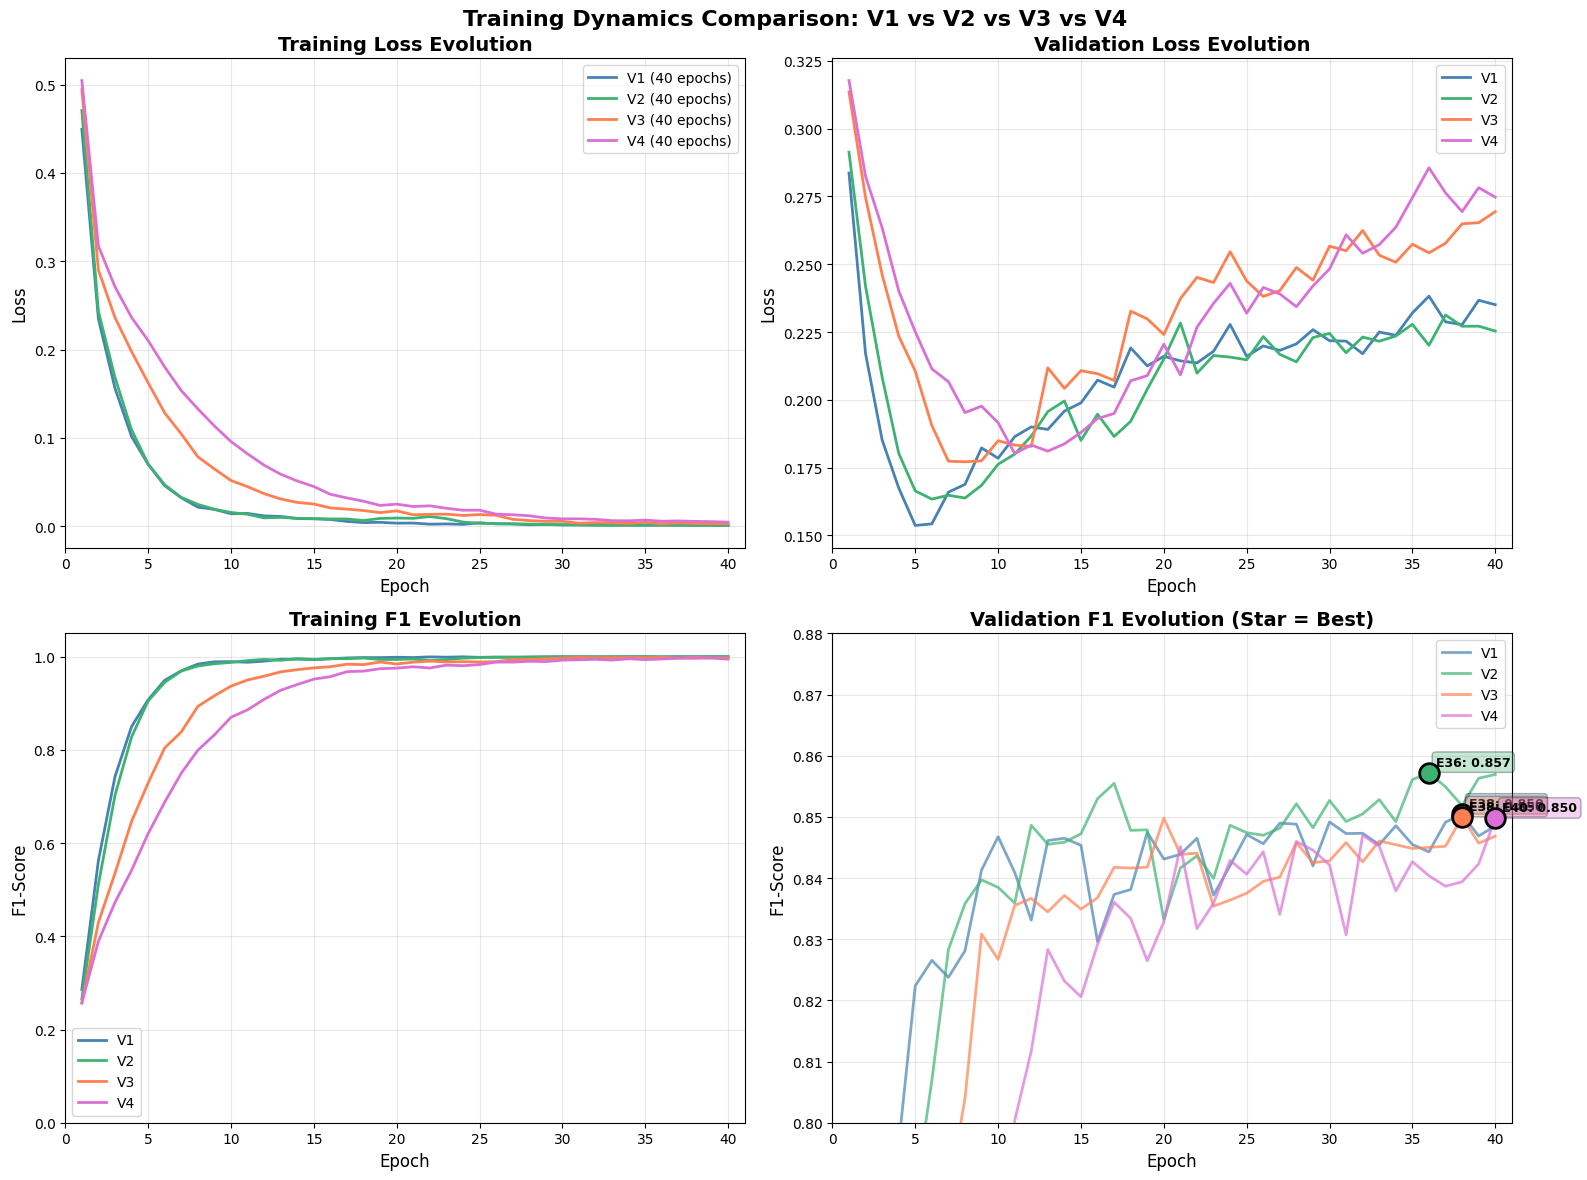


✅ Gráfico salvo: training_curves_comparison_all.png


In [39]:
# ==================== TRAINING CURVES ====================
import matplotlib.pyplot as plt
import numpy as np

# Histories já carregados
configs = ['v1', 'v2', 'v3', 'v4']
colors = {'v1': 'steelblue', 'v2': 'mediumseagreen', 'v3': 'coral', 'v4': 'orchid'}

histories = {}

print("📂 Loading history files...")
print("="*70)

for config in configs:
    history_file = f'efficientnet_{config}_history.npy'
    
    if Path(history_file).exists():
        # Carregar history
        history_data = np.load(history_file, allow_pickle=True).item()
        histories[config] = history_data
        
        # Verificar conteúdo
        num_epochs = len(history_data['train_loss'])
        final_train_f1 = history_data['train_f1'][-1]
        final_val_f1 = history_data['val_f1'][-1]
        best_val_f1 = max(history_data['val_f1'])
        
        print(f"✅ {config.upper()}: {num_epochs} epochs")
        print(f"   Train F1: {final_train_f1:.4f}")
        print(f"   Val F1:   {final_val_f1:.4f}")
        print(f"   Best Val: {best_val_f1:.4f}")
    else:
        print(f"❌ {config.upper()}: File not found - {history_file}")

print("="*70)
print(f"✅ Loaded {len(histories)}/{len(configs)} history files\n")

# ==================== PLOT COM EPOCHS DINÂMICOS ====================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training Dynamics Comparison: V1 vs V2 vs V3 vs V4', 
             fontsize=16, fontweight='bold')

# PLOT 1: Train Loss
ax = axes[0, 0]
for config in configs:
    if config in histories:
        num_epochs = len(histories[config]['train_loss'])
        epochs = range(1, num_epochs + 1)
        ax.plot(epochs, histories[config]['train_loss'], 
               label=f'{config.upper()} ({num_epochs} epochs)', 
               color=colors[config], linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Loss Evolution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim([0, 41])

# PLOT 2: Val Loss
ax = axes[0, 1]
for config in configs:
    if config in histories:
        num_epochs = len(histories[config]['val_loss'])
        epochs = range(1, num_epochs + 1)
        ax.plot(epochs, histories[config]['val_loss'], 
               label=f'{config.upper()}', 
               color=colors[config], linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Validation Loss Evolution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim([0, 41])

# PLOT 3: Train F1
ax = axes[1, 0]
for config in configs:
    if config in histories:
        num_epochs = len(histories[config]['train_f1'])
        epochs = range(1, num_epochs + 1)
        ax.plot(epochs, histories[config]['train_f1'], 
               label=f'{config.upper()}', 
               color=colors[config], linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Training F1 Evolution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim([0, 41])
ax.set_ylim([0, 1.05])

# PLOT 4: Val F1 (com best epoch marcado)
ax = axes[1, 1]
for config in configs:
    if config in histories:
        val_f1 = histories[config]['val_f1']
        num_epochs = len(val_f1)
        epochs = range(1, num_epochs + 1)
        
        ax.plot(epochs, val_f1, 
               label=f'{config.upper()}', 
               color=colors[config], linewidth=2, alpha=0.7)
        
        # Marcar best epoch
        best_epoch = np.argmax(val_f1)
        best_f1 = val_f1[best_epoch]
        ax.scatter(best_epoch + 1, best_f1, 
                  color=colors[config], s=200, zorder=5, 
                  edgecolor='black', linewidth=2)
        ax.annotate(f'E{best_epoch + 1}: {best_f1:.3f}', 
                   xy=(best_epoch + 1, best_f1), 
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', 
                            facecolor=colors[config], alpha=0.3))

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Validation F1 Evolution (Star = Best)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim([0, 41])
ax.set_ylim([0.80, 0.88])

plt.tight_layout()
plt.savefig('training_curves_comparison_all.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico salvo: training_curves_comparison_all.png")

BEST EPOCH ANALYSIS

V1
Best Epoch:           38/40
Best Val F1:          0.8504
Train F1 (at best):   0.9996
Gap (Train - Val):    0.1492 (17.5%)
Val Loss (at best):   0.2277
Train Loss (at best): 0.0010
Plateau after:        Epoch 40
Epochs wasted:        0 epochs

V2
Best Epoch:           36/40
Best Val F1:          0.8572
Train F1 (at best):   0.9996
Gap (Train - Val):    0.1423 (16.6%)
Val Loss (at best):   0.2201
Train Loss (at best): 0.0010
Plateau after:        Epoch 37
Epochs wasted:        3 epochs

📊 Overfitting progression:
  Train F1: 0.9996 → 0.9996 (+-0.0000)
  Val F1:   0.8572 → 0.8569 (-0.0003)

V3
Best Epoch:           38/40
Best Val F1:          0.8500
Train F1 (at best):   0.9985
Gap (Train - Val):    0.1485 (17.5%)
Val Loss (at best):   0.2649
Train Loss (at best): 0.0030
Plateau after:        Epoch 40
Epochs wasted:        0 epochs

V4
Best Epoch:           40/40
Best Val F1:          0.8497
Train F1 (at best):   0.9946
Gap (Train - Val):    0.1448 (17.0%)
Val Los

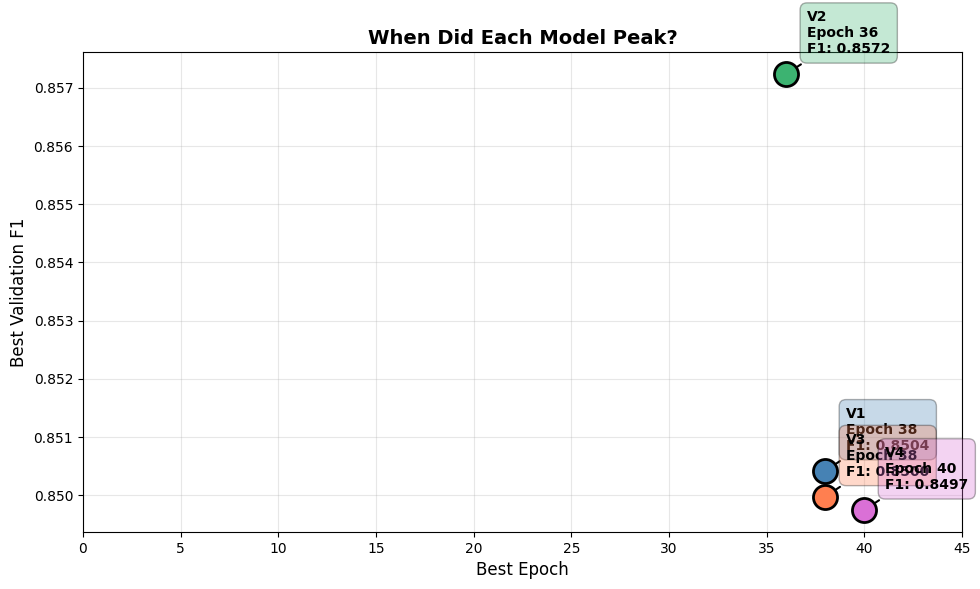


✅ Análise completa! Verificar imagens geradas.


In [40]:
# ==================== ANÁLISE DE BEST EPOCHS ====================

print("="*70)
print("BEST EPOCH ANALYSIS")
print("="*70)

best_epochs_data = []

for config in configs:
    if config not in histories:
        continue
    
    val_f1 = histories[config]['val_f1']
    train_f1 = histories[config]['train_f1']
    val_loss = histories[config]['val_loss']
    train_loss = histories[config]['train_loss']
    
    best_epoch = np.argmax(val_f1)
    best_val_f1 = val_f1[best_epoch]
    
    # Métricas no best epoch
    train_f1_at_best = train_f1[best_epoch]
    val_loss_at_best = val_loss[best_epoch]
    train_loss_at_best = train_loss[best_epoch]
    
    # Gap train-val
    gap_f1 = train_f1_at_best - best_val_f1
    
    # Verificar se houve early plateau
    plateau_start = None
    for i in range(best_epoch + 1, len(val_f1)):
        if val_f1[i] < best_val_f1 - 0.005:  # Se caiu >0.5%
            plateau_start = i
            break
    
    if plateau_start is None:
        plateau_start = len(val_f1)
    
    print(f"\n{'='*70}")
    print(f"{config.upper()}")
    print(f"{'='*70}")
    print(f"Best Epoch:           {best_epoch + 1}/40")
    print(f"Best Val F1:          {best_val_f1:.4f}")
    print(f"Train F1 (at best):   {train_f1_at_best:.4f}")
    print(f"Gap (Train - Val):    {gap_f1:.4f} ({gap_f1/best_val_f1*100:.1f}%)")
    print(f"Val Loss (at best):   {val_loss_at_best:.4f}")
    print(f"Train Loss (at best): {train_loss_at_best:.4f}")
    print(f"Plateau after:        Epoch {plateau_start}")
    print(f"Epochs wasted:        {40 - plateau_start} epochs")
    
    # Verificar overfitting progression
    if plateau_start < 40:
        final_train_f1 = train_f1[-1]
        final_val_f1 = val_f1[-1]
        overfit_increase = (final_train_f1 - train_f1_at_best)
        
        print(f"\n📊 Overfitting progression:")
        print(f"  Train F1: {train_f1_at_best:.4f} → {final_train_f1:.4f} (+{overfit_increase:.4f})")
        print(f"  Val F1:   {best_val_f1:.4f} → {final_val_f1:.4f} ({final_val_f1 - best_val_f1:+.4f})")
    
    best_epochs_data.append({
        'config': config,
        'best_epoch': best_epoch + 1,
        'best_val_f1': best_val_f1,
        'train_f1_at_best': train_f1_at_best,
        'gap_percent': gap_f1/best_val_f1*100,
        'plateau_epoch': plateau_start
    })

# Criar tabela comparativa
print("\n" + "="*70)
print("SUMMARY TABLE")
print("="*70)

import pandas as pd
df_epochs = pd.DataFrame(best_epochs_data)
df_epochs = df_epochs.sort_values('best_val_f1', ascending=False)
print(df_epochs.to_string(index=False))

# Plot best epochs
fig, ax = plt.subplots(figsize=(10, 6))

for data in best_epochs_data:
    config = data['config']
    best_epoch = data['best_epoch']
    best_val_f1 = data['best_val_f1']
    
    ax.scatter(best_epoch, best_val_f1, s=300, color=colors[config], 
              edgecolor='black', linewidth=2, zorder=5, label=config.upper())
    ax.annotate(f"{config.upper()}\nEpoch {best_epoch}\nF1: {best_val_f1:.4f}", 
               xy=(best_epoch, best_val_f1), 
               xytext=(15, 15), textcoords='offset points',
               fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[config], alpha=0.3),
               arrowprops=dict(arrowstyle='->', lw=1.5))

ax.set_xlabel('Best Epoch', fontsize=12)
ax.set_ylabel('Best Validation F1', fontsize=12)
ax.set_title('When Did Each Model Peak?', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xlim([0, 45])

plt.tight_layout()
plt.savefig('best_epochs_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Análise completa! Verificar imagens geradas.")

TRANSFORM VERIFICATION
  📂 test: 959 pacients, 1748 images
  📂 test: 959 pacients, 1748 images
  📂 test: 959 pacients, 1748 images
  📂 test: 959 pacients, 1748 images

V1:
  Patient ID: 2678
  Image shape: torch.Size([3, 224, 224])
  Image mean: -0.9520
  Image std: 1.0481
  Min/Max: -2.1179 / 2.2489
  ⚠️ Normalization unexpected!

V2:
  Patient ID: 2678
  Image shape: torch.Size([3, 224, 224])
  Image mean: -0.9358
  Image std: 1.0483
  Min/Max: -2.1179 / 2.2489
  ⚠️ Normalization unexpected!

V3:
  Patient ID: 2678
  Image shape: torch.Size([3, 224, 224])
  Image mean: -0.9713
  Image std: 1.0706
  Min/Max: -2.1179 / 2.1119
  ⚠️ Normalization unexpected!

V4:
  Patient ID: 2678
  Image shape: torch.Size([3, 224, 224])
  Image mean: -0.5558
  Image std: 1.3137
  Min/Max: -2.1179 / 2.4286
  ⚠️ Normalization unexpected!


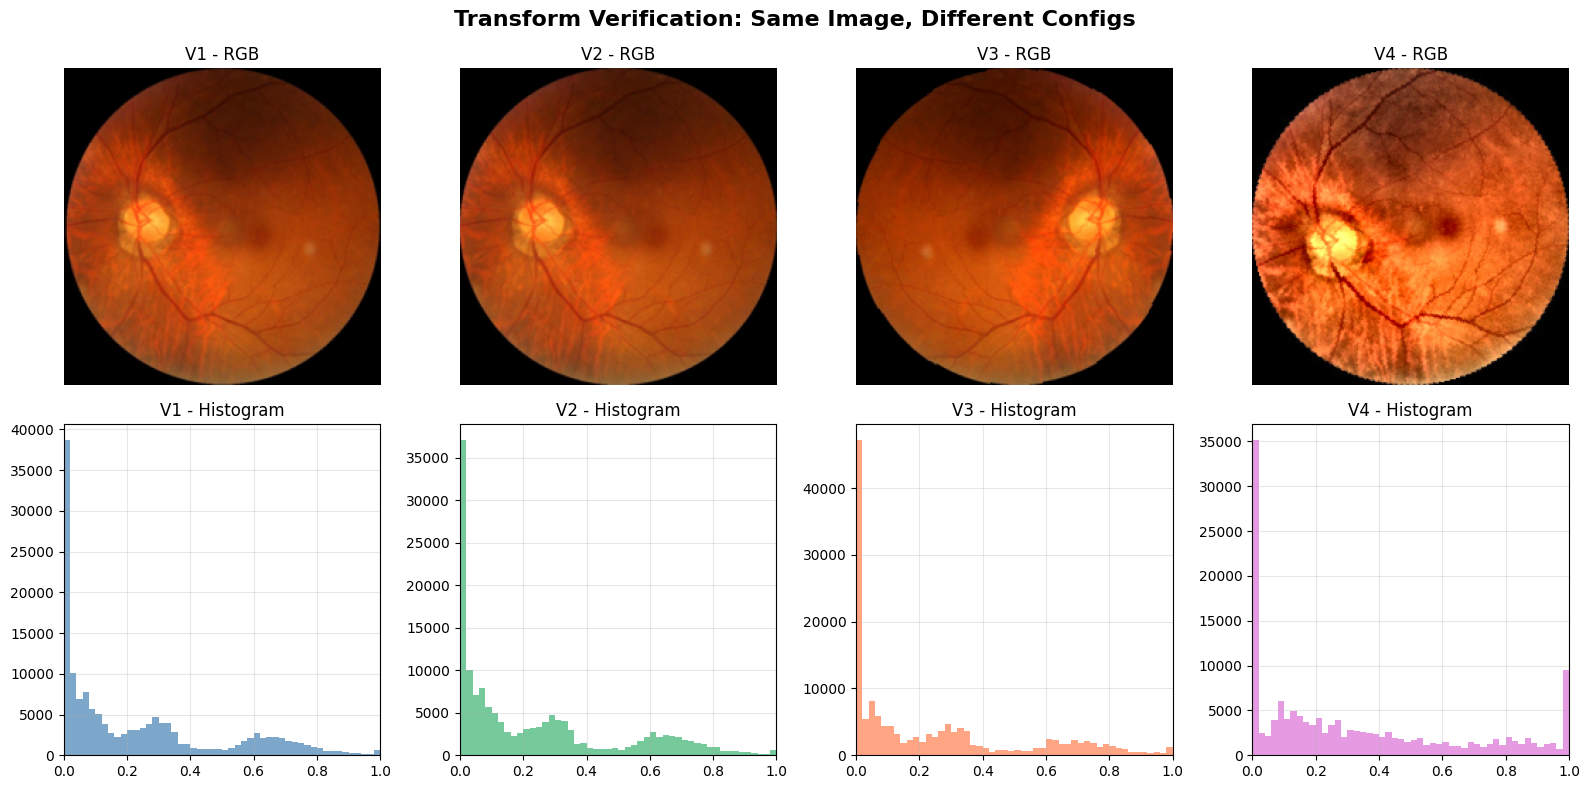


✅ Transform verification complete!


In [41]:
# ==================== VERIFICAR TRANSFORMS ====================
import torch
from torchvision import transforms

print("="*70)
print("TRANSFORM VERIFICATION")
print("="*70)

# Criar datasets
datasets_verify = {
    'v1': ODIRDataset('test', transform=get_v1_baseline_transform()),
    'v2': ODIRDataset('test', transform=get_v2_crop_only_transform()),
    'v3': ODIRDataset('test', transform=get_v3_crop_aug_transform()),
    'v4': ODIRDataset('test', transform=get_v4_full_pipeline_transform())
}

# Pegar mesma imagem em todos
sample_idx = 0
original_img_path = None

for config, dataset in datasets_verify.items():
    img, labels, patient_id = dataset[sample_idx]
    
    print(f"\n{config.upper()}:")
    print(f"  Patient ID: {patient_id}")
    print(f"  Image shape: {img.shape}")
    print(f"  Image mean: {img.mean():.4f}")
    print(f"  Image std: {img.std():.4f}")
    print(f"  Min/Max: {img.min():.4f} / {img.max():.4f}")
    
    # Verificar normalização
    expected_mean = 0.0  # Aproximado, ImageNet normalized
    expected_std = 1.0
    
    actual_mean = img.mean()
    actual_std = img.std()
    
    if abs(actual_mean) < 0.5 and 0.5 < actual_std < 1.5:
        print(f"  ✅ Normalization OK")
    else:
        print(f"  ⚠️ Normalization unexpected!")

# Visualizar diferenças
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Transform Verification: Same Image, Different Configs', 
             fontsize=16, fontweight='bold')

for idx, (config, dataset) in enumerate(datasets_verify.items()):
    # Sem augmentation (usar transform de test)
    img, _, patient_id = dataset[sample_idx]
    
    # Denormalize para visualização
    img_vis = img.numpy().transpose(1, 2, 0)
    img_vis = img_vis * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_vis = np.clip(img_vis, 0, 1)
    
    # Plot original
    axes[0, idx].imshow(img_vis)
    axes[0, idx].set_title(f'{config.upper()} - RGB')
    axes[0, idx].axis('off')
    
    # Plot histogram
    axes[1, idx].hist(img_vis.ravel(), bins=50, color=colors[config], alpha=0.7)
    axes[1, idx].set_title(f'{config.upper()} - Histogram')
    axes[1, idx].set_xlim([0, 1])
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('transform_verification.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Transform verification complete!")

In [42]:
# ==================== ERROR ANALYSIS ====================

# Carregar modelos
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = {}
for config in configs:
    model = EfficientNetB0MultiLabel(num_classes=8).to(device)
    checkpoint = torch.load(f'efficientnet_{config}_best.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    models[config] = model

# Dataset de teste (usar V1 transform para comparação justa)
test_dataset = ODIRDataset('test', transform=get_val_test_transform())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Fazer predições
all_predictions = {config: [] for config in configs}
all_labels = []
all_patient_ids = []

print("🔍 Fazendo predições com todos os modelos...")

with torch.no_grad():
    for images, labels, patient_ids in tqdm(test_loader):
        images = images.to(device)
        
        for config, model in models.items():
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_predictions[config].append(preds)
        
        all_labels.append(labels.numpy())
        all_patient_ids.extend(patient_ids)

# Concatenar
for config in configs:
    all_predictions[config] = np.vstack(all_predictions[config])

all_labels = np.vstack(all_labels)

print(f"\n✅ Predições completas: {len(all_patient_ids)} pacientes")

# Binarizar predições
threshold = 0.5
predictions_binary = {
    config: (preds > threshold).astype(int) 
    for config, preds in all_predictions.items()
}

# Encontrar disagreements
print("\n" + "="*70)
print("DISAGREEMENT ANALYSIS")
print("="*70)

class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Casos onde V1 acerta e V3 erra (e vice-versa)
v1_correct = (predictions_binary['v1'] == all_labels)
v3_correct = (predictions_binary['v3'] == all_labels)

v1_wins = v1_correct & ~v3_correct
v3_wins = ~v1_correct & v3_correct

print(f"\nV1 acerta e V3 erra: {v1_wins.sum()} casos")
print(f"V3 acerta e V1 erra: {v3_wins.sum()} casos")
print(f"Ambos acertam: {(v1_correct & v3_correct).sum()} casos")
print(f"Ambos erram: {(~v1_correct & ~v3_correct).sum()} casos")

# Ver padrões por classe
print("\n📊 Disagreements por classe:")
for class_idx, class_name in enumerate(class_names):
    v1_class_wins = v1_wins[:, class_idx].sum()
    v3_class_wins = v3_wins[:, class_idx].sum()
    
    print(f"\n{class_name}:")
    print(f"  V1 wins: {v1_class_wins} casos")
    print(f"  V3 wins: {v3_class_wins} casos")
    print(f"  Net: V1 {'+' if v1_class_wins > v3_class_wins else ''}{v1_class_wins - v3_class_wins}")

# Encontrar "hard cases" - onde TODOS erraram
all_wrong = np.ones(all_labels.shape, dtype=bool)
for config in configs:
    all_wrong &= (predictions_binary[config] != all_labels)

hard_cases_count = all_wrong.sum(axis=0)

print("\n🔴 HARD CASES (todos os modelos erraram):")
for class_idx, class_name in enumerate(class_names):
    count = hard_cases_count[class_idx]
    total = all_labels[:, class_idx].sum()
    pct = count / total * 100 if total > 0 else 0
    print(f"  {class_name}: {count}/{total} ({pct:.1f}%)")

print("\n✅ Error analysis complete!")

  📂 test: 959 pacients, 1748 images
🔍 Fazendo predições com todos os modelos...


100%|██████████| 30/30 [00:10<00:00,  3.00it/s]


✅ Predições completas: 959 pacientes

DISAGREEMENT ANALYSIS

V1 acerta e V3 erra: 104 casos
V3 acerta e V1 erra: 122 casos
Ambos acertam: 7216 casos
Ambos erram: 230 casos

📊 Disagreements por classe:

N:
  V1 wins: 39 casos
  V3 wins: 39 casos
  Net: V1 0

D:
  V1 wins: 24 casos
  V3 wins: 33 casos
  Net: V1 -9

G:
  V1 wins: 7 casos
  V3 wins: 5 casos
  Net: V1 +2

C:
  V1 wins: 3 casos
  V3 wins: 1 casos
  Net: V1 +2

A:
  V1 wins: 0 casos
  V3 wins: 0 casos
  Net: V1 0

H:
  V1 wins: 2 casos
  V3 wins: 3 casos
  Net: V1 -1

M:
  V1 wins: 0 casos
  V3 wins: 4 casos
  Net: V1 -4

O:
  V1 wins: 29 casos
  V3 wins: 37 casos
  Net: V1 -8

🔴 HARD CASES (todos os modelos erraram):
  N: 30/299.0 (10.0%)
  D: 41/340.0 (12.1%)
  G: 9/69.0 (13.0%)
  C: 10/59.0 (16.9%)
  A: 11/51.0 (21.6%)
  H: 14/42.0 (33.3%)
  M: 2/42.0 (4.8%)
  O: 38/229.0 (16.6%)

✅ Error analysis complete!


In [43]:
# ==================== STATISTICAL SIGNIFICANCE ====================
from scipy import stats

print("="*70)
print("STATISTICAL SIGNIFICANCE TESTS")
print("="*70)

# Per-sample F1 scores
per_sample_f1 = {}

for config in configs:
    preds = predictions_binary[config]
    labels = all_labels
    
    # Calcular F1 por amostra
    sample_f1s = []
    for i in range(len(preds)):
        if labels[i].sum() == 0:  # Skip if no positive labels
            continue
        f1 = f1_score(labels[i], preds[i], average='macro', zero_division=0)
        sample_f1s.append(f1)
    
    per_sample_f1[config] = np.array(sample_f1s)

# T-tests pairwise
print("\n📊 Paired t-tests (V1 vs others):")

for config in ['v2', 'v3', 'v4']:
    t_stat, p_value = stats.ttest_rel(per_sample_f1['v1'], per_sample_f1[config])
    
    mean_v1 = per_sample_f1['v1'].mean()
    mean_other = per_sample_f1[config].mean()
    
    print(f"\nV1 vs {config.upper()}:")
    print(f"  V1 mean:     {mean_v1:.4f}")
    print(f"  {config.upper()} mean:     {mean_other:.4f}")
    print(f"  Difference:  {mean_v1 - mean_other:+.4f}")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value:     {p_value:.4f}")
    
    if p_value < 0.05:
        print(f"  ✅ SIGNIFICANT difference (p < 0.05)")
    else:
        print(f"  ⚠️ NOT significant (p ≥ 0.05) - likely RANDOM!")

# Effect size (Cohen's d)
print("\n📏 Effect Sizes (Cohen's d):")
for config in ['v2', 'v3', 'v4']:
    pooled_std = np.sqrt((per_sample_f1['v1'].std()**2 + per_sample_f1[config].std()**2) / 2)
    cohens_d = (per_sample_f1['v1'].mean() - per_sample_f1[config].mean()) / pooled_std
    
    print(f"V1 vs {config.upper()}: d = {cohens_d:.3f}", end="")
    
    if abs(cohens_d) < 0.2:
        print(" (negligible)")
    elif abs(cohens_d) < 0.5:
        print(" (small)")
    elif abs(cohens_d) < 0.8:
        print(" (medium)")
    else:
        print(" (large)")

print("\n✅ Statistical analysis complete!")

STATISTICAL SIGNIFICANCE TESTS

📊 Paired t-tests (V1 vs others):

V1 vs V2:
  V1 mean:     0.8864
  V2 mean:     0.8917
  Difference:  -0.0054
  t-statistic: -1.076
  p-value:     0.2823
  ⚠️ NOT significant (p ≥ 0.05) - likely RANDOM!

V1 vs V3:
  V1 mean:     0.8864
  V3 mean:     0.8949
  Difference:  -0.0085
  t-statistic: -1.839
  p-value:     0.0663
  ⚠️ NOT significant (p ≥ 0.05) - likely RANDOM!

V1 vs V4:
  V1 mean:     0.8864
  V4 mean:     0.7767
  Difference:  +0.1097
  t-statistic: 13.164
  p-value:     0.0000
  ✅ SIGNIFICANT difference (p < 0.05)

📏 Effect Sizes (Cohen's d):
V1 vs V2: d = -0.025 (negligible)
V1 vs V3: d = -0.040 (negligible)
V1 vs V4: d = 0.460 (small)

✅ Statistical analysis complete!


In [44]:
print("\n📂 Preparing validation and test datasets...")

# Validation dataset (para otimização)
val_v4 = ODIRDataset('val', transform=get_v4_val_transform())
val_loader_v4 = DataLoader(
    val_v4, 
    batch_size=32, 
    shuffle=False,
    num_workers=2, 
    pin_memory=True
)

# Test dataset (para avaliação final)
test_v4 = ODIRDataset('test', transform=get_v4_val_transform())
test_loader_v4 = DataLoader(
    test_v4, 
    batch_size=32, 
    shuffle=False,
    num_workers=2, 
    pin_memory=True
)

print(f"✅ Datasets ready:")
print(f"   Validation: {len(val_v4)} samples")
print(f"   Test:       {len(test_v4)} samples")


📂 Preparing validation and test datasets...
  📂 val: 959 pacients, 1728 images
  📂 test: 959 pacients, 1748 images
✅ Datasets ready:
   Validation: 959 samples
   Test:       959 samples


In [45]:
# Executar otimização
optimal_thresholds = optimize_thresholds(model_v4, val_loader_v4, device)

# Mostrar thresholds
print(f"\n{'='*70}")
print("✅ OPTIMAL THRESHOLDS FOUND")
print(f"{'='*70}")

class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
for name, thresh in zip(class_names, optimal_thresholds):
    print(f"  {name}: {thresh:.3f}")

# Salvar thresholds
np.save('/kaggle/working/optimal_thresholds_v4_FINAL.npy', optimal_thresholds)
print(f"\n✅ Thresholds saved: optimal_thresholds_v4_FINAL.npy")
print(f"{'='*70}")


🔍 OPTIMIZING THRESHOLDS



Class    Default F1   Best F1      Threshold    Gain      
------------------------------------------------------------
N        0.8333       0.8467       0.81          +0.0134
D        0.8382       0.8395       0.51          +0.0014
G        0.8496       0.8621       0.13          +0.0125
C        0.9128       0.9315       0.91          +0.0188
A        0.8462       0.8462       0.25          +0.0000
H        0.8372       0.8372       0.47          +0.0000
M        0.9643       0.9643       0.31          +0.0000
O        0.7165       0.7375       0.17          +0.0210
------------------------------------------------------------
Average gain: +0.0084


✅ OPTIMAL THRESHOLDS FOUND
  N: 0.810
  D: 0.510
  G: 0.130
  C: 0.910
  A: 0.250
  H: 0.470
  M: 0.310
  O: 0.170

✅ Thresholds saved: optimal_thresholds_v4_FINAL.npy


In [46]:
print("\n" + "="*80)
print("📊 EVALUATING TEST SET WITH OPTIMIZED THRESHOLDS")
print("="*80)

model_v4.eval()

# Coletar predições test
test_probs = []
test_labels = []

with torch.no_grad():
    for images, labels, _ in tqdm(test_loader_v4, desc='Testing'):
        images = images.to(device)
        outputs = torch.sigmoid(model_v4(images))
        test_probs.append(outputs.cpu().numpy())
        test_labels.append(labels.numpy())

test_probs = np.concatenate(test_probs)
test_labels = np.concatenate(test_labels)

# ==================== COMPARAÇÃO ====================

class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Default (threshold=0.5)
test_preds_default = (test_probs > 0.5).astype(int)
test_f1_default = f1_score(test_labels, test_preds_default, 
                           average='macro', zero_division=0)
per_class_f1_default = f1_score(test_labels, test_preds_default, 
                               average=None, zero_division=0)

# Optimized
test_preds_optimized = np.zeros_like(test_probs)
for i in range(8):
    test_preds_optimized[:, i] = (test_probs[:, i] > optimal_thresholds[i]).astype(int)

test_f1_optimized = f1_score(test_labels, test_preds_optimized, 
                            average='macro', zero_division=0)
per_class_f1_optimized = f1_score(test_labels, test_preds_optimized,
                                  average=None, zero_division=0)

# ==================== RESULTADOS ====================

print("\n" + "="*80)
print("🏆 FINAL RESULTS - V4 OPTIMIZED")
print("="*80)

print(f"\n📊 OVERALL TEST F1-SCORE:")
print(f"  V4 Default (threshold=0.5):    {test_f1_default:.4f}")
print(f"  V4 Optimized thresholds:       {test_f1_optimized:.4f}")
print(f"  Improvement:                   {test_f1_optimized - test_f1_default:+.4f} "
      f"({(test_f1_optimized/test_f1_default - 1)*100:+.1f}%)")

print(f"\n📊 PER-CLASS F1-SCORE COMPARISON:")
print(f"{'Class':<8} {'Default':<10} {'Optimized':<10} {'Threshold':<12} {'Gain':<10}")
print("-" * 65)

for i, name in enumerate(class_names):
    default = per_class_f1_default[i]
    optimized = per_class_f1_optimized[i]
    gain = optimized - default
    
    marker = "  [OK][OK]" if gain > 0.05 else "  [OK]" if gain > 0.02 else ""
    
    print(f"{name:<8} {default:.4f}     {optimized:.4f}     "
          f"{optimal_thresholds[i]:.2f}          {gain:+.4f}{marker}")

print("-" * 65)


📊 EVALUATING TEST SET WITH OPTIMIZED THRESHOLDS


Testing: 100%|██████████| 30/30 [00:08<00:00,  3.56it/s]


🏆 FINAL RESULTS - V4 OPTIMIZED

📊 OVERALL TEST F1-SCORE:
  V4 Default (threshold=0.5):    0.8474
  V4 Optimized thresholds:       0.8485
  Improvement:                   +0.0011 (+0.1%)

📊 PER-CLASS F1-SCORE COMPARISON:
Class    Default    Optimized  Threshold    Gain      
-----------------------------------------------------------------
N        0.8441     0.8432     0.81          -0.0009
D        0.8584     0.8584     0.51          +0.0000
G        0.8525     0.8594     0.13          +0.0069
C        0.8718     0.8793     0.91          +0.0075
A        0.8539     0.8539     0.25          +0.0000
H        0.7606     0.7606     0.47          +0.0000
M        0.9756     0.9756     0.31          +0.0000
O        0.7624     0.7577     0.17          -0.0046
-----------------------------------------------------------------


In [47]:
# ==================== XAI (GRAD-CAM) PARA EFFICIENTNET-B0 ====================

!pip install grad-cam

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from tqdm import tqdm

print("="*80)
print(" EXPLAINABLE AI (GRAD-CAM) - EFFICIENTNET V4")
print("="*80)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carregar modelo V4 best
model_v4 = EfficientNetB0MultiLabel(num_classes=8, dropout=0.2)
checkpoint = torch.load('/kaggle/working/efficientnet_v4_best.pth', map_location=device)

# 3. Se guardaste com torch.save({'model_state_dict': ...}), tens de aceder à chave
if 'model_state_dict' in checkpoint:
    model_v4.load_state_dict(checkpoint['model_state_dict'])
else:
    model_v4.load_state_dict(checkpoint)

model_v4 = model_v4.to(device).eval()

print(f" V4 model loaded on {device}")

# Test dataset e loader
xai_test_ds = ODIRDataset('test', transform=get_v4_val_transform())
xai_test_loader = DataLoader(xai_test_ds, batch_size=32, shuffle=False)

print(f" Test dataset: {len(xai_test_ds)} samples")

target_layers = [model_v4.model.conv_head]

def generate_xai_reports_efficientnet(model, test_loader, device, 
                                      target_layers, version_name='V4_Best',
                                      max_cases_per_type=3):
    """
    Gerar Grad-CAM visualizations para EfficientNet
    """
    
    model.eval()
    
    # Criar Grad-CAM
    cam = GradCAM(model=model, target_layers=target_layers)
    
    class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    xai_data_for_report = []
    
    # Contador de casos
    counts = {"SUCCESS": 0, "FAILURE": 0}
    
    print(f"\n{'='*80}")
    print(f"Generating Grad-CAM visualizations for {version_name}")
    print(f"{'='*80}")
    print(f"Target: {max_cases_per_type} SUCCESS cases + {max_cases_per_type} FAILURE cases")
    print(f"{'='*80}\n")
    
    # Iterar test set
    for imgs, labels, img_ids in tqdm(test_loader, desc='Processing'):
        
        imgs_dev = imgs.to(device)
        
        # Forward pass
        with torch.no_grad():
            outputs = model(imgs_dev)
            probs = torch.sigmoid(outputs)
        
        # Predictions
        preds = (probs > 0.5).int().cpu().numpy()
        labels_np = labels.numpy()
        probs_np = probs.cpu().numpy()
        
        # Processar cada imagem no batch
        for i in range(imgs.shape[0]):
            
            # Check se predição está correta (multi-label)
            is_correct = np.array_equal(preds[i], labels_np[i])
            case_type = "SUCCESS" if is_correct else "FAILURE"
            
            # Check se já temos casos suficientes
            if counts[case_type] >= max_cases_per_type:
                continue
            
            counts[case_type] += 1
            
            # ==================== GRAD-CAM ====================
            
            # Para multi-label, vamos gerar Grad-CAM para classe ground truth
            # Se houver múltiplas, escolher a mais confiante
            gt_classes = np.where(labels_np[i] == 1)[0]
            
            if len(gt_classes) == 0:
                continue  # Skip se sem ground truth
            
            # Escolher classe ground truth com maior probabilidade
            target_class_idx = gt_classes[np.argmax(probs_np[i][gt_classes])]
            
            # Target para Grad-CAM
            targets = [ClassifierOutputTarget(target_class_idx)]
            
            # Gerar Grad-CAM
            grayscale_cam = cam(input_tensor=imgs_dev[i:i+1], targets=targets)[0, :]
            
            # ==================== VISUALIZAÇÃO ====================
            
            # Denormalizar imagem
            img_original = imgs[i].permute(1, 2, 0).numpy()
            
            # Normalizar para [0, 1]
            img_min = img_original.min()
            img_max = img_original.max()
            if img_max > img_min:
                img_original = (img_original - img_min) / (img_max - img_min)
            else:
                img_original = np.zeros_like(img_original)
            
            # Overlay Grad-CAM
            visualization = show_cam_on_image(img_original, grayscale_cam, use_rgb=True)
            
            # ==================== SALVAR ====================
            
            filename = f"xai_{version_name.lower()}_{case_type.lower()}_case{counts[case_type]}.png"
            
            # Criar figura
            fig, axes = plt.subplots(1, 3, figsize=(20, 7))
            
            # Original
            axes[0].imshow(img_original)
            axes[0].set_title(f"Original Image\nID: {img_ids[i]}", fontsize=12, fontweight='bold')
            axes[0].axis('off')
            
            # Grad-CAM heatmap
            axes[1].imshow(grayscale_cam, cmap='jet')
            axes[1].set_title(f"Grad-CAM Heatmap\nTarget: {class_names[target_class_idx]}", 
                            fontsize=12, fontweight='bold')
            axes[1].axis('off')
            
            # Overlay
            axes[2].imshow(visualization)
            
            # Título detalhado
            gt_str = ', '.join([class_names[j] for j in gt_classes])
            pred_classes = np.where(preds[i] == 1)[0]
            pred_str = ', '.join([class_names[j] for j in pred_classes]) if len(pred_classes) > 0 else 'None'
            
            title = f"Grad-CAM Overlay - {case_type}\n"
            title += f"Ground Truth: {gt_str}\n"
            title += f"Prediction: {pred_str}\n"
            title += f"Confidence: {probs_np[i][target_class_idx]:.3f}"
            
            axes[2].set_title(title, fontsize=11, fontweight='bold')
            axes[2].axis('off')
            
            plt.tight_layout()
            plt.savefig(f'/kaggle/working/{filename}', dpi=150, bbox_inches='tight')
            plt.close()
            
            # ==================== METADATA ====================
            
            case_info = {
                "case_id": counts[case_type],
                "image_id": str(img_ids[i]),
                "case_type": case_type,
                "image_file": filename,
                "ground_truth": {
                    "classes": [class_names[j] for j in gt_classes],
                    "binary": labels_np[i].tolist()
                },
                "prediction": {
                    "classes": [class_names[j] for j in pred_classes] if len(pred_classes) > 0 else [],
                    "binary": preds[i].tolist()
                },
                "confidence_scores": {
                    class_names[j]: float(probs_np[i][j]) for j in range(8)
                },
                "gradcam_target_class": class_names[target_class_idx],
                "gradcam_confidence": float(probs_np[i][target_class_idx])
            }
            
            xai_data_for_report.append(case_info)
            
            print(f"  ✅ Generated: {filename} ({case_type}, target={class_names[target_class_idx]})")
        
        # Stop se já há casos suficientes
        if counts["SUCCESS"] >= max_cases_per_type and counts["FAILURE"] >= max_cases_per_type:
            break
        
    json_filename = f"xai_metadata_{version_name.lower()}.json"
    
    with open(f'/kaggle/working/{json_filename}', 'w') as f:
        json.dump(xai_data_for_report, f, indent=4)
        
    print(f"\n{'='*80}")
    print("✅ GRAD-CAM GENERATION COMPLETE!")
    print(f"{'='*80}")
    print(f"  SUCCESS cases: {counts['SUCCESS']}")
    print(f"  FAILURE cases: {counts['FAILURE']}")
    print(f"  Total cases:   {counts['SUCCESS'] + counts['FAILURE']}")
    print(f"\n📁 Files generated:")
    print(f"  - Images: xai_{version_name.lower()}_*.png")
    print(f"  - Metadata: {json_filename}")
    print(f"{'='*80}\n")
    
    return xai_data_for_report

xai_results = generate_xai_reports_efficientnet(
    model=model_v4,
    test_loader=xai_test_loader,
    device=device,
    target_layers=target_layers,
    version_name='V4_EfficientNet',
    max_cases_per_type=5  # 5 SUCCESS + 5 FAILURE
)

print("✅ XAI analysis complete!")
print("   Download the images and JSON for your report!")

 EXPLAINABLE AI (GRAD-CAM) - EFFICIENTNET V4
 V4 model loaded on cuda
  📂 test: 959 pacients, 1748 images
 Test dataset: 959 samples

Generating Grad-CAM visualizations for V4_EfficientNet
Target: 5 SUCCESS cases + 5 FAILURE cases



Processing:   0%|          | 0/30 [00:00<?, ?it/s]

  ✅ Generated: xai_v4_efficientnet_success_case1.png (SUCCESS, target=N)
  ✅ Generated: xai_v4_efficientnet_success_case2.png (SUCCESS, target=N)
  ✅ Generated: xai_v4_efficientnet_success_case3.png (SUCCESS, target=D)
  ✅ Generated: xai_v4_efficientnet_success_case4.png (SUCCESS, target=N)
  ✅ Generated: xai_v4_efficientnet_success_case5.png (SUCCESS, target=N)
  ✅ Generated: xai_v4_efficientnet_failure_case1.png (FAILURE, target=D)
  ✅ Generated: xai_v4_efficientnet_failure_case2.png (FAILURE, target=D)


Processing:   3%|▎         | 1/30 [00:05<02:44,  5.69s/it]

  ✅ Generated: xai_v4_efficientnet_failure_case3.png (FAILURE, target=N)
  ✅ Generated: xai_v4_efficientnet_failure_case4.png (FAILURE, target=M)


Processing:   3%|▎         | 1/30 [00:07<03:39,  7.56s/it]

  ✅ Generated: xai_v4_efficientnet_failure_case5.png (FAILURE, target=D)

✅ GRAD-CAM GENERATION COMPLETE!
  SUCCESS cases: 5
  FAILURE cases: 5
  Total cases:   10

📁 Files generated:
  - Images: xai_v4_efficientnet_*.png
  - Metadata: xai_metadata_v4_efficientnet.json

✅ XAI analysis complete!
   Download the images and JSON for your report!


In [48]:
# 5-fold
from sklearn.model_selection import KFold

full_train_dataset = ODIRDataset('train', transform=get_v4_full_pipeline_transform())

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# train e val originais juntos para re-dividir
indices = np.arange(len(full_train_dataset)) 

all_fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
    print(f"\n🚀 A INICIAR FOLD {fold+1}/{n_splits}")
    
    # Cria subsets de dados para fold específico
    train_sub = torch.utils.data.Subset(full_train_dataset, train_idx)
    val_sub   = torch.utils.data.Subset(full_train_dataset, val_idx)
    
    results, model, history = train_model_complete(
        train_sub, val_sub, test_v4, 
        config_name=f'v4_fold_{fold+1}', 
        num_epochs=40, 
        batch_size=32, 
        lr=1e-4
    )
    
    all_fold_metrics.append(results['test_f1'])
    
    # Limpar memória para o próximo fold
    del model
    torch.cuda.empty_cache()

print(f"\n📊 Média Final F1 (K-Fold): {np.mean(all_fold_metrics):.4f} (+/- {np.std(all_fold_metrics):.4f})")

  📂 train: 4474 pacients, 5732 images

🚀 A INICIAR FOLD 1/5

TRAINING EFFICIENTNET-B0 - V4_FOLD_1


🚀 Device: cuda
📊 Model: 4,017,796 parameters
⚠️  Using standard BCE (no class weights)


Epoch 1/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.13it/s]



Epoch 1/40:
  Train - Loss: 0.5478, F1: 0.2522, Acc: 0.7791
  Val   - Loss: 0.3467, F1: 0.3842, Acc: 0.8554
  LR: 1.00e-04, Time: 47.8s
  ✅ Best model saved! (F1: 0.3842)


Epoch 2/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 2/40:
  Train - Loss: 0.3479, F1: 0.3705, Acc: 0.8543
  Val   - Loss: 0.3085, F1: 0.3649, Acc: 0.8648
  LR: 1.00e-04, Time: 46.4s


Epoch 3/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.15it/s]



Epoch 3/40:
  Train - Loss: 0.2903, F1: 0.4393, Acc: 0.8741
  Val   - Loss: 0.2783, F1: 0.4494, Acc: 0.8746
  LR: 1.00e-04, Time: 46.6s
  ✅ Best model saved! (F1: 0.4494)


Epoch 4/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.13it/s]



Epoch 4/40:
  Train - Loss: 0.2539, F1: 0.5013, Acc: 0.8886
  Val   - Loss: 0.2661, F1: 0.5040, Acc: 0.8874
  LR: 1.00e-04, Time: 47.0s
  ✅ Best model saved! (F1: 0.5040)


Epoch 5/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 5/40:
  Train - Loss: 0.2301, F1: 0.5532, Acc: 0.9003
  Val   - Loss: 0.2546, F1: 0.5271, Acc: 0.8885
  LR: 1.00e-04, Time: 46.4s
  ✅ Best model saved! (F1: 0.5271)


Epoch 6/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 6/40:
  Train - Loss: 0.2028, F1: 0.6345, Acc: 0.9153
  Val   - Loss: 0.2419, F1: 0.5662, Acc: 0.8993
  LR: 1.00e-04, Time: 46.1s
  ✅ Best model saved! (F1: 0.5662)


Epoch 7/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.15it/s]



Epoch 7/40:
  Train - Loss: 0.1765, F1: 0.6864, Acc: 0.9262
  Val   - Loss: 0.2282, F1: 0.6257, Acc: 0.9078
  LR: 1.00e-04, Time: 46.9s
  ✅ Best model saved! (F1: 0.6257)


Epoch 8/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 8/40:
  Train - Loss: 0.1593, F1: 0.7514, Acc: 0.9347
  Val   - Loss: 0.2175, F1: 0.6790, Acc: 0.9134
  LR: 1.00e-04, Time: 46.0s
  ✅ Best model saved! (F1: 0.6790)


Epoch 9/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.18it/s]



Epoch 9/40:
  Train - Loss: 0.1362, F1: 0.7887, Acc: 0.9466
  Val   - Loss: 0.2083, F1: 0.6685, Acc: 0.9184
  LR: 1.00e-04, Time: 46.2s


Epoch 10/40 [Val]: 100%|██████████| 28/28 [00:09<00:00,  3.10it/s]



Epoch 10/40:
  Train - Loss: 0.1218, F1: 0.8206, Acc: 0.9532
  Val   - Loss: 0.2057, F1: 0.7159, Acc: 0.9226
  LR: 1.00e-04, Time: 46.9s
  ✅ Best model saved! (F1: 0.7159)


Epoch 11/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.18it/s]



Epoch 11/40:
  Train - Loss: 0.1015, F1: 0.8591, Acc: 0.9628
  Val   - Loss: 0.1949, F1: 0.7608, Acc: 0.9293
  LR: 1.00e-04, Time: 46.3s
  ✅ Best model saved! (F1: 0.7608)


Epoch 12/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 12/40:
  Train - Loss: 0.0915, F1: 0.8652, Acc: 0.9662
  Val   - Loss: 0.2006, F1: 0.7522, Acc: 0.9302
  LR: 1.00e-04, Time: 46.6s


Epoch 13/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 13/40:
  Train - Loss: 0.0780, F1: 0.8872, Acc: 0.9705
  Val   - Loss: 0.1973, F1: 0.7551, Acc: 0.9332
  LR: 1.00e-04, Time: 46.1s


Epoch 14/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.11it/s]



Epoch 14/40:
  Train - Loss: 0.0648, F1: 0.9226, Acc: 0.9775
  Val   - Loss: 0.2013, F1: 0.7668, Acc: 0.9337
  LR: 1.00e-04, Time: 46.3s
  ✅ Best model saved! (F1: 0.7668)


Epoch 15/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]



Epoch 15/40:
  Train - Loss: 0.0582, F1: 0.9271, Acc: 0.9802
  Val   - Loss: 0.2051, F1: 0.7812, Acc: 0.9363
  LR: 1.00e-04, Time: 46.8s
  ✅ Best model saved! (F1: 0.7812)


Epoch 16/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.11it/s]



Epoch 16/40:
  Train - Loss: 0.0516, F1: 0.9421, Acc: 0.9825
  Val   - Loss: 0.2008, F1: 0.7917, Acc: 0.9401
  LR: 1.00e-04, Time: 46.3s
  ✅ Best model saved! (F1: 0.7917)


Epoch 17/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 17/40:
  Train - Loss: 0.0449, F1: 0.9455, Acc: 0.9854
  Val   - Loss: 0.2024, F1: 0.7982, Acc: 0.9402
  LR: 1.00e-04, Time: 46.1s
  ✅ Best model saved! (F1: 0.7982)


Epoch 18/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 18/40:
  Train - Loss: 0.0387, F1: 0.9552, Acc: 0.9867
  Val   - Loss: 0.2071, F1: 0.7965, Acc: 0.9402
  LR: 1.00e-04, Time: 46.0s


Epoch 19/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.18it/s]



Epoch 19/40:
  Train - Loss: 0.0370, F1: 0.9630, Acc: 0.9877
  Val   - Loss: 0.2067, F1: 0.7995, Acc: 0.9390
  LR: 1.00e-04, Time: 46.4s
  ✅ Best model saved! (F1: 0.7995)


Epoch 20/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.18it/s]



Epoch 20/40:
  Train - Loss: 0.0324, F1: 0.9617, Acc: 0.9893
  Val   - Loss: 0.2203, F1: 0.8058, Acc: 0.9412
  LR: 1.00e-04, Time: 46.6s
  ✅ Best model saved! (F1: 0.8058)


Epoch 21/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 21/40:
  Train - Loss: 0.0304, F1: 0.9689, Acc: 0.9905
  Val   - Loss: 0.2245, F1: 0.7997, Acc: 0.9390
  LR: 1.00e-04, Time: 46.3s


Epoch 22/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 22/40:
  Train - Loss: 0.0283, F1: 0.9669, Acc: 0.9904
  Val   - Loss: 0.2300, F1: 0.7939, Acc: 0.9378
  LR: 1.00e-04, Time: 46.7s


Epoch 23/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.14it/s]



Epoch 23/40:
  Train - Loss: 0.0231, F1: 0.9754, Acc: 0.9929
  Val   - Loss: 0.2350, F1: 0.7994, Acc: 0.9413
  LR: 1.00e-04, Time: 46.3s


Epoch 24/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.13it/s]



Epoch 24/40:
  Train - Loss: 0.0231, F1: 0.9721, Acc: 0.9926
  Val   - Loss: 0.2323, F1: 0.7960, Acc: 0.9383
  LR: 1.00e-04, Time: 46.9s


Epoch 25/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]



Epoch 25/40:
  Train - Loss: 0.0209, F1: 0.9818, Acc: 0.9933
  Val   - Loss: 0.2273, F1: 0.8077, Acc: 0.9412
  LR: 1.00e-04, Time: 46.0s
  ✅ Best model saved! (F1: 0.8077)


Epoch 26/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 26/40:
  Train - Loss: 0.0206, F1: 0.9815, Acc: 0.9934
  Val   - Loss: 0.2495, F1: 0.7980, Acc: 0.9381
  LR: 1.00e-04, Time: 46.1s


Epoch 27/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.14it/s]



Epoch 27/40:
  Train - Loss: 0.0181, F1: 0.9840, Acc: 0.9941
  Val   - Loss: 0.2335, F1: 0.8040, Acc: 0.9413
  LR: 1.00e-04, Time: 46.8s


Epoch 28/40 [Val]: 100%|██████████| 28/28 [00:09<00:00,  2.99it/s]



Epoch 28/40:
  Train - Loss: 0.0191, F1: 0.9820, Acc: 0.9938
  Val   - Loss: 0.2347, F1: 0.7960, Acc: 0.9409
  LR: 1.00e-04, Time: 48.7s


Epoch 29/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 29/40:
  Train - Loss: 0.0162, F1: 0.9854, Acc: 0.9954
  Val   - Loss: 0.2425, F1: 0.7988, Acc: 0.9391
  LR: 1.00e-04, Time: 46.6s


Epoch 30/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.18it/s]



Epoch 30/40:
  Train - Loss: 0.0153, F1: 0.9849, Acc: 0.9951
  Val   - Loss: 0.2515, F1: 0.7992, Acc: 0.9397
  LR: 1.00e-04, Time: 46.5s


Epoch 31/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]



Epoch 31/40:
  Train - Loss: 0.0150, F1: 0.9888, Acc: 0.9954
  Val   - Loss: 0.2513, F1: 0.7980, Acc: 0.9402
  LR: 5.00e-05, Time: 46.3s


Epoch 32/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 32/40:
  Train - Loss: 0.0123, F1: 0.9897, Acc: 0.9966
  Val   - Loss: 0.2479, F1: 0.8052, Acc: 0.9398
  LR: 5.00e-05, Time: 46.5s


Epoch 33/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 33/40:
  Train - Loss: 0.0102, F1: 0.9925, Acc: 0.9971
  Val   - Loss: 0.2500, F1: 0.8016, Acc: 0.9392
  LR: 5.00e-05, Time: 46.3s


Epoch 34/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.12it/s]



Epoch 34/40:
  Train - Loss: 0.0096, F1: 0.9924, Acc: 0.9973
  Val   - Loss: 0.2532, F1: 0.7969, Acc: 0.9408
  LR: 5.00e-05, Time: 47.0s


Epoch 35/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 35/40:
  Train - Loss: 0.0075, F1: 0.9953, Acc: 0.9983
  Val   - Loss: 0.2375, F1: 0.8052, Acc: 0.9451
  LR: 5.00e-05, Time: 46.5s


Epoch 36/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 36/40:
  Train - Loss: 0.0078, F1: 0.9941, Acc: 0.9978
  Val   - Loss: 0.2473, F1: 0.8052, Acc: 0.9423
  LR: 5.00e-05, Time: 46.1s


Epoch 37/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]



Epoch 37/40:
  Train - Loss: 0.0075, F1: 0.9933, Acc: 0.9980
  Val   - Loss: 0.2770, F1: 0.7911, Acc: 0.9363
  LR: 2.50e-05, Time: 46.4s


Epoch 38/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.19it/s]



Epoch 38/40:
  Train - Loss: 0.0061, F1: 0.9946, Acc: 0.9985
  Val   - Loss: 0.2671, F1: 0.7914, Acc: 0.9394
  LR: 2.50e-05, Time: 45.8s


Epoch 39/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.18it/s]



Epoch 39/40:
  Train - Loss: 0.0063, F1: 0.9960, Acc: 0.9984
  Val   - Loss: 0.2542, F1: 0.7988, Acc: 0.9409
  LR: 2.50e-05, Time: 46.0s


Epoch 40/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.14it/s]



Epoch 40/40:
  Train - Loss: 0.0052, F1: 0.9966, Acc: 0.9988
  Val   - Loss: 0.2643, F1: 0.8090, Acc: 0.9423
  LR: 2.50e-05, Time: 47.3s
  ✅ Best model saved! (F1: 0.8090)

EVALUATING ON TEST SET



Testing: 100%|██████████| 30/30 [00:09<00:00,  3.19it/s]



📊 FINAL TEST RESULTS - V4_FOLD_1:
  Accuracy:  0.9403
  F1-Score:  0.7858
  Kappa:     0.7462
  Avg Epoch Time: 46.5s
  Avg Inference:  0.42ms/image

  Per-class F1:
    N: 0.7892
    D: 0.8110
    G: 0.7350
    C: 0.8305
    A: 0.8140
    H: 0.6462
    M: 0.9383
    O: 0.7220

📊 Generating visualizations for report...
✅ Visualizations saved:
   - efficientnet_v4_fold_1_training_curves.png
   - efficientnet_v4_fold_1_confusion_matrices.png
   - efficientnet_v4_fold_1_per_class_f1.png
   - efficientnet_v4_fold_1_results.json
   - efficientnet_v4_fold_1_history.npy

🚀 A INICIAR FOLD 2/5

TRAINING EFFICIENTNET-B0 - V4_FOLD_2


🚀 Device: cuda
📊 Model: 4,017,796 parameters
⚠️  Using standard BCE (no class weights)


Epoch 1/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 1/40:
  Train - Loss: 0.5182, F1: 0.2370, Acc: 0.7855
  Val   - Loss: 0.3530, F1: 0.3240, Acc: 0.8482
  LR: 1.00e-04, Time: 46.3s
  ✅ Best model saved! (F1: 0.3240)


Epoch 2/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.19it/s]



Epoch 2/40:
  Train - Loss: 0.3217, F1: 0.3708, Acc: 0.8606
  Val   - Loss: 0.3148, F1: 0.3550, Acc: 0.8631
  LR: 1.00e-04, Time: 46.2s
  ✅ Best model saved! (F1: 0.3550)


Epoch 3/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]



Epoch 3/40:
  Train - Loss: 0.2789, F1: 0.4359, Acc: 0.8777
  Val   - Loss: 0.3018, F1: 0.4194, Acc: 0.8694
  LR: 1.00e-04, Time: 45.4s
  ✅ Best model saved! (F1: 0.4194)


Epoch 4/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]



Epoch 4/40:
  Train - Loss: 0.2525, F1: 0.4998, Acc: 0.8897
  Val   - Loss: 0.2905, F1: 0.4334, Acc: 0.8747
  LR: 1.00e-04, Time: 46.0s
  ✅ Best model saved! (F1: 0.4334)


Epoch 5/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 5/40:
  Train - Loss: 0.2254, F1: 0.5733, Acc: 0.9021
  Val   - Loss: 0.2800, F1: 0.4836, Acc: 0.8806
  LR: 1.00e-04, Time: 46.1s
  ✅ Best model saved! (F1: 0.4836)


Epoch 6/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.14it/s]



Epoch 6/40:
  Train - Loss: 0.1977, F1: 0.6226, Acc: 0.9146
  Val   - Loss: 0.2624, F1: 0.5583, Acc: 0.8901
  LR: 1.00e-04, Time: 46.5s
  ✅ Best model saved! (F1: 0.5583)


Epoch 7/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.26it/s]



Epoch 7/40:
  Train - Loss: 0.1753, F1: 0.6786, Acc: 0.9274
  Val   - Loss: 0.2526, F1: 0.5839, Acc: 0.9011
  LR: 1.00e-04, Time: 45.7s
  ✅ Best model saved! (F1: 0.5839)


Epoch 8/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 8/40:
  Train - Loss: 0.1521, F1: 0.7443, Acc: 0.9373
  Val   - Loss: 0.2411, F1: 0.6282, Acc: 0.9057
  LR: 1.00e-04, Time: 46.1s
  ✅ Best model saved! (F1: 0.6282)


Epoch 9/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.23it/s]



Epoch 9/40:
  Train - Loss: 0.1294, F1: 0.7888, Acc: 0.9471
  Val   - Loss: 0.2486, F1: 0.6543, Acc: 0.9073
  LR: 1.00e-04, Time: 45.7s
  ✅ Best model saved! (F1: 0.6543)


Epoch 10/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.23it/s]



Epoch 10/40:
  Train - Loss: 0.1142, F1: 0.8240, Acc: 0.9554
  Val   - Loss: 0.2438, F1: 0.6904, Acc: 0.9137
  LR: 1.00e-04, Time: 45.7s
  ✅ Best model saved! (F1: 0.6904)


Epoch 11/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.24it/s]



Epoch 11/40:
  Train - Loss: 0.1018, F1: 0.8491, Acc: 0.9598
  Val   - Loss: 0.2404, F1: 0.7059, Acc: 0.9170
  LR: 1.00e-04, Time: 45.9s
  ✅ Best model saved! (F1: 0.7059)


Epoch 12/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.28it/s]



Epoch 12/40:
  Train - Loss: 0.0815, F1: 0.8919, Acc: 0.9714
  Val   - Loss: 0.2430, F1: 0.7033, Acc: 0.9189
  LR: 1.00e-04, Time: 45.7s


Epoch 13/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]



Epoch 13/40:
  Train - Loss: 0.0685, F1: 0.9026, Acc: 0.9744
  Val   - Loss: 0.2396, F1: 0.7390, Acc: 0.9240
  LR: 1.00e-04, Time: 45.4s
  ✅ Best model saved! (F1: 0.7390)


Epoch 14/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.19it/s]



Epoch 14/40:
  Train - Loss: 0.0627, F1: 0.9171, Acc: 0.9778
  Val   - Loss: 0.2416, F1: 0.7557, Acc: 0.9282
  LR: 1.00e-04, Time: 46.3s
  ✅ Best model saved! (F1: 0.7557)


Epoch 15/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.26it/s]



Epoch 15/40:
  Train - Loss: 0.0565, F1: 0.9300, Acc: 0.9798
  Val   - Loss: 0.2490, F1: 0.7540, Acc: 0.9253
  LR: 1.00e-04, Time: 45.7s


Epoch 16/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 16/40:
  Train - Loss: 0.0476, F1: 0.9365, Acc: 0.9837
  Val   - Loss: 0.2696, F1: 0.7756, Acc: 0.9291
  LR: 1.00e-04, Time: 46.1s
  ✅ Best model saved! (F1: 0.7756)


Epoch 17/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.14it/s]



Epoch 17/40:
  Train - Loss: 0.0409, F1: 0.9505, Acc: 0.9862
  Val   - Loss: 0.2512, F1: 0.7827, Acc: 0.9334
  LR: 1.00e-04, Time: 46.4s
  ✅ Best model saved! (F1: 0.7827)


Epoch 18/40 [Val]: 100%|██████████| 28/28 [00:09<00:00,  3.10it/s]



Epoch 18/40:
  Train - Loss: 0.0372, F1: 0.9616, Acc: 0.9877
  Val   - Loss: 0.2570, F1: 0.7740, Acc: 0.9296
  LR: 1.00e-04, Time: 47.3s


Epoch 19/40 [Val]: 100%|██████████| 28/28 [00:09<00:00,  3.08it/s]



Epoch 19/40:
  Train - Loss: 0.0318, F1: 0.9647, Acc: 0.9897
  Val   - Loss: 0.2568, F1: 0.7865, Acc: 0.9359
  LR: 1.00e-04, Time: 47.6s
  ✅ Best model saved! (F1: 0.7865)


Epoch 20/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.11it/s]



Epoch 20/40:
  Train - Loss: 0.0305, F1: 0.9721, Acc: 0.9901
  Val   - Loss: 0.2760, F1: 0.7799, Acc: 0.9303
  LR: 1.00e-04, Time: 47.7s


Epoch 21/40 [Val]: 100%|██████████| 28/28 [00:09<00:00,  3.10it/s]



Epoch 21/40:
  Train - Loss: 0.0279, F1: 0.9714, Acc: 0.9909
  Val   - Loss: 0.2703, F1: 0.7759, Acc: 0.9327
  LR: 1.00e-04, Time: 47.1s


Epoch 22/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 22/40:
  Train - Loss: 0.0255, F1: 0.9728, Acc: 0.9913
  Val   - Loss: 0.2736, F1: 0.7822, Acc: 0.9334
  LR: 1.00e-04, Time: 46.9s


Epoch 23/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.12it/s]



Epoch 23/40:
  Train - Loss: 0.0219, F1: 0.9770, Acc: 0.9933
  Val   - Loss: 0.2818, F1: 0.7833, Acc: 0.9327
  LR: 1.00e-04, Time: 46.6s


Epoch 24/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.14it/s]



Epoch 24/40:
  Train - Loss: 0.0196, F1: 0.9800, Acc: 0.9936
  Val   - Loss: 0.2804, F1: 0.7838, Acc: 0.9335
  LR: 1.00e-04, Time: 47.2s


Epoch 25/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 25/40:
  Train - Loss: 0.0201, F1: 0.9802, Acc: 0.9935
  Val   - Loss: 0.2833, F1: 0.7771, Acc: 0.9332
  LR: 5.00e-05, Time: 46.7s


Epoch 26/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.15it/s]



Epoch 26/40:
  Train - Loss: 0.0160, F1: 0.9790, Acc: 0.9947
  Val   - Loss: 0.3116, F1: 0.7758, Acc: 0.9334
  LR: 5.00e-05, Time: 46.1s


Epoch 27/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.15it/s]



Epoch 27/40:
  Train - Loss: 0.0136, F1: 0.9887, Acc: 0.9962
  Val   - Loss: 0.3002, F1: 0.7714, Acc: 0.9338
  LR: 5.00e-05, Time: 46.5s


Epoch 28/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.24it/s]



Epoch 28/40:
  Train - Loss: 0.0129, F1: 0.9917, Acc: 0.9964
  Val   - Loss: 0.3065, F1: 0.7884, Acc: 0.9332
  LR: 5.00e-05, Time: 46.1s
  ✅ Best model saved! (F1: 0.7884)


Epoch 29/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 29/40:
  Train - Loss: 0.0121, F1: 0.9872, Acc: 0.9967
  Val   - Loss: 0.3021, F1: 0.7924, Acc: 0.9338
  LR: 5.00e-05, Time: 46.4s
  ✅ Best model saved! (F1: 0.7924)


Epoch 30/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.24it/s]



Epoch 30/40:
  Train - Loss: 0.0122, F1: 0.9898, Acc: 0.9960
  Val   - Loss: 0.3083, F1: 0.7802, Acc: 0.9332
  LR: 5.00e-05, Time: 45.7s


Epoch 31/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 31/40:
  Train - Loss: 0.0102, F1: 0.9921, Acc: 0.9972
  Val   - Loss: 0.2944, F1: 0.7894, Acc: 0.9348
  LR: 5.00e-05, Time: 46.6s


Epoch 32/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 32/40:
  Train - Loss: 0.0088, F1: 0.9921, Acc: 0.9975
  Val   - Loss: 0.3242, F1: 0.7875, Acc: 0.9352
  LR: 5.00e-05, Time: 46.6s


Epoch 33/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.19it/s]



Epoch 33/40:
  Train - Loss: 0.0089, F1: 0.9912, Acc: 0.9976
  Val   - Loss: 0.3223, F1: 0.7734, Acc: 0.9317
  LR: 5.00e-05, Time: 46.3s


Epoch 34/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 34/40:
  Train - Loss: 0.0090, F1: 0.9912, Acc: 0.9975
  Val   - Loss: 0.3187, F1: 0.7886, Acc: 0.9339
  LR: 5.00e-05, Time: 46.0s


Epoch 35/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 35/40:
  Train - Loss: 0.0089, F1: 0.9919, Acc: 0.9971
  Val   - Loss: 0.3291, F1: 0.7827, Acc: 0.9337
  LR: 2.50e-05, Time: 46.0s


Epoch 36/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.24it/s]



Epoch 36/40:
  Train - Loss: 0.0082, F1: 0.9950, Acc: 0.9980
  Val   - Loss: 0.3194, F1: 0.7878, Acc: 0.9352
  LR: 2.50e-05, Time: 46.5s


Epoch 37/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.32it/s]



Epoch 37/40:
  Train - Loss: 0.0061, F1: 0.9967, Acc: 0.9987
  Val   - Loss: 0.3370, F1: 0.7838, Acc: 0.9338
  LR: 2.50e-05, Time: 45.7s


Epoch 38/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 38/40:
  Train - Loss: 0.0061, F1: 0.9961, Acc: 0.9986
  Val   - Loss: 0.3168, F1: 0.7892, Acc: 0.9358
  LR: 2.50e-05, Time: 45.6s


Epoch 39/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.19it/s]



Epoch 39/40:
  Train - Loss: 0.0064, F1: 0.9944, Acc: 0.9984
  Val   - Loss: 0.3268, F1: 0.7841, Acc: 0.9345
  LR: 2.50e-05, Time: 46.2s


Epoch 40/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 40/40:
  Train - Loss: 0.0059, F1: 0.9957, Acc: 0.9985
  Val   - Loss: 0.3439, F1: 0.7821, Acc: 0.9316
  LR: 2.50e-05, Time: 46.5s

EVALUATING ON TEST SET



Testing: 100%|██████████| 30/30 [00:09<00:00,  3.19it/s]



📊 FINAL TEST RESULTS - V4_FOLD_2:
  Accuracy:  0.9334
  F1-Score:  0.7670
  Kappa:     0.7232
  Avg Epoch Time: 46.3s
  Avg Inference:  0.38ms/image

  Per-class F1:
    N: 0.7567
    D: 0.7857
    G: 0.7059
    C: 0.8182
    A: 0.7294
    H: 0.7164
    M: 0.9383
    O: 0.6859

📊 Generating visualizations for report...
✅ Visualizations saved:
   - efficientnet_v4_fold_2_training_curves.png
   - efficientnet_v4_fold_2_confusion_matrices.png
   - efficientnet_v4_fold_2_per_class_f1.png
   - efficientnet_v4_fold_2_results.json
   - efficientnet_v4_fold_2_history.npy

🚀 A INICIAR FOLD 3/5

TRAINING EFFICIENTNET-B0 - V4_FOLD_3


🚀 Device: cuda
📊 Model: 4,017,796 parameters
⚠️  Using standard BCE (no class weights)


Epoch 1/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 1/40:
  Train - Loss: 0.5467, F1: 0.2359, Acc: 0.7790
  Val   - Loss: 0.3461, F1: 0.3611, Acc: 0.8497
  LR: 1.00e-04, Time: 46.6s
  ✅ Best model saved! (F1: 0.3611)


Epoch 2/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.24it/s]



Epoch 2/40:
  Train - Loss: 0.3279, F1: 0.3663, Acc: 0.8595
  Val   - Loss: 0.3070, F1: 0.4016, Acc: 0.8698
  LR: 1.00e-04, Time: 45.4s
  ✅ Best model saved! (F1: 0.4016)


Epoch 3/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 3/40:
  Train - Loss: 0.2869, F1: 0.4383, Acc: 0.8744
  Val   - Loss: 0.2947, F1: 0.4022, Acc: 0.8729
  LR: 1.00e-04, Time: 46.0s
  ✅ Best model saved! (F1: 0.4022)


Epoch 4/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 4/40:
  Train - Loss: 0.2558, F1: 0.4970, Acc: 0.8880
  Val   - Loss: 0.2795, F1: 0.4409, Acc: 0.8785
  LR: 1.00e-04, Time: 46.0s
  ✅ Best model saved! (F1: 0.4409)


Epoch 5/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 5/40:
  Train - Loss: 0.2253, F1: 0.5735, Acc: 0.9021
  Val   - Loss: 0.2696, F1: 0.5073, Acc: 0.8872
  LR: 1.00e-04, Time: 46.2s
  ✅ Best model saved! (F1: 0.5073)


Epoch 6/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 6/40:
  Train - Loss: 0.2039, F1: 0.6409, Acc: 0.9129
  Val   - Loss: 0.2538, F1: 0.5850, Acc: 0.8985
  LR: 1.00e-04, Time: 45.8s
  ✅ Best model saved! (F1: 0.5850)


Epoch 7/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.24it/s]



Epoch 7/40:
  Train - Loss: 0.1792, F1: 0.6921, Acc: 0.9248
  Val   - Loss: 0.2451, F1: 0.5878, Acc: 0.8996
  LR: 1.00e-04, Time: 46.3s
  ✅ Best model saved! (F1: 0.5878)


Epoch 8/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.27it/s]



Epoch 8/40:
  Train - Loss: 0.1555, F1: 0.7476, Acc: 0.9365
  Val   - Loss: 0.2358, F1: 0.6478, Acc: 0.9085
  LR: 1.00e-04, Time: 46.0s
  ✅ Best model saved! (F1: 0.6478)


Epoch 9/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.18it/s]



Epoch 9/40:
  Train - Loss: 0.1349, F1: 0.7840, Acc: 0.9446
  Val   - Loss: 0.2304, F1: 0.6480, Acc: 0.9126
  LR: 1.00e-04, Time: 46.5s
  ✅ Best model saved! (F1: 0.6480)


Epoch 10/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 10/40:
  Train - Loss: 0.1154, F1: 0.8173, Acc: 0.9531
  Val   - Loss: 0.2313, F1: 0.6921, Acc: 0.9172
  LR: 1.00e-04, Time: 45.8s
  ✅ Best model saved! (F1: 0.6921)


Epoch 11/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]



Epoch 11/40:
  Train - Loss: 0.1002, F1: 0.8608, Acc: 0.9627
  Val   - Loss: 0.2271, F1: 0.7146, Acc: 0.9232
  LR: 1.00e-04, Time: 46.5s
  ✅ Best model saved! (F1: 0.7146)


Epoch 12/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 12/40:
  Train - Loss: 0.0844, F1: 0.8786, Acc: 0.9691
  Val   - Loss: 0.2222, F1: 0.7345, Acc: 0.9240
  LR: 1.00e-04, Time: 46.2s
  ✅ Best model saved! (F1: 0.7345)


Epoch 13/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 13/40:
  Train - Loss: 0.0734, F1: 0.9018, Acc: 0.9738
  Val   - Loss: 0.2241, F1: 0.7526, Acc: 0.9303
  LR: 1.00e-04, Time: 46.2s
  ✅ Best model saved! (F1: 0.7526)


Epoch 14/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 14/40:
  Train - Loss: 0.0635, F1: 0.9234, Acc: 0.9769
  Val   - Loss: 0.2239, F1: 0.7596, Acc: 0.9307
  LR: 1.00e-04, Time: 45.8s
  ✅ Best model saved! (F1: 0.7596)


Epoch 15/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.14it/s]



Epoch 15/40:
  Train - Loss: 0.0556, F1: 0.9288, Acc: 0.9806
  Val   - Loss: 0.2243, F1: 0.7492, Acc: 0.9307
  LR: 1.00e-04, Time: 46.4s


Epoch 16/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 16/40:
  Train - Loss: 0.0475, F1: 0.9432, Acc: 0.9838
  Val   - Loss: 0.2281, F1: 0.7799, Acc: 0.9348
  LR: 1.00e-04, Time: 45.7s
  ✅ Best model saved! (F1: 0.7799)


Epoch 17/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.19it/s]



Epoch 17/40:
  Train - Loss: 0.0398, F1: 0.9498, Acc: 0.9865
  Val   - Loss: 0.2524, F1: 0.7660, Acc: 0.9342
  LR: 1.00e-04, Time: 46.4s


Epoch 18/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 18/40:
  Train - Loss: 0.0377, F1: 0.9553, Acc: 0.9870
  Val   - Loss: 0.2436, F1: 0.7855, Acc: 0.9342
  LR: 1.00e-04, Time: 46.3s
  ✅ Best model saved! (F1: 0.7855)


Epoch 19/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.24it/s]



Epoch 19/40:
  Train - Loss: 0.0338, F1: 0.9587, Acc: 0.9892
  Val   - Loss: 0.2559, F1: 0.7764, Acc: 0.9358
  LR: 1.00e-04, Time: 45.9s


Epoch 20/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]



Epoch 20/40:
  Train - Loss: 0.0302, F1: 0.9643, Acc: 0.9898
  Val   - Loss: 0.2552, F1: 0.7789, Acc: 0.9356
  LR: 1.00e-04, Time: 45.8s


Epoch 21/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.23it/s]



Epoch 21/40:
  Train - Loss: 0.0266, F1: 0.9724, Acc: 0.9914
  Val   - Loss: 0.2510, F1: 0.7851, Acc: 0.9352
  LR: 1.00e-04, Time: 46.0s


Epoch 22/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 22/40:
  Train - Loss: 0.0271, F1: 0.9719, Acc: 0.9914
  Val   - Loss: 0.2579, F1: 0.7701, Acc: 0.9346
  LR: 1.00e-04, Time: 46.0s


Epoch 23/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 23/40:
  Train - Loss: 0.0238, F1: 0.9770, Acc: 0.9923
  Val   - Loss: 0.2609, F1: 0.7857, Acc: 0.9341
  LR: 1.00e-04, Time: 45.9s
  ✅ Best model saved! (F1: 0.7857)


Epoch 24/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 24/40:
  Train - Loss: 0.0191, F1: 0.9835, Acc: 0.9942
  Val   - Loss: 0.2684, F1: 0.7849, Acc: 0.9372
  LR: 1.00e-04, Time: 46.3s


Epoch 25/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.19it/s]



Epoch 25/40:
  Train - Loss: 0.0195, F1: 0.9802, Acc: 0.9935
  Val   - Loss: 0.2595, F1: 0.7850, Acc: 0.9381
  LR: 1.00e-04, Time: 46.1s


Epoch 26/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 26/40:
  Train - Loss: 0.0204, F1: 0.9811, Acc: 0.9932
  Val   - Loss: 0.3047, F1: 0.7825, Acc: 0.9355
  LR: 1.00e-04, Time: 45.7s


Epoch 27/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.19it/s]



Epoch 27/40:
  Train - Loss: 0.0186, F1: 0.9819, Acc: 0.9946
  Val   - Loss: 0.2698, F1: 0.7800, Acc: 0.9367
  LR: 1.00e-04, Time: 46.0s


Epoch 28/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.23it/s]



Epoch 28/40:
  Train - Loss: 0.0168, F1: 0.9841, Acc: 0.9943
  Val   - Loss: 0.2957, F1: 0.7827, Acc: 0.9381
  LR: 1.00e-04, Time: 45.6s


Epoch 29/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.23it/s]



Epoch 29/40:
  Train - Loss: 0.0167, F1: 0.9818, Acc: 0.9945
  Val   - Loss: 0.2767, F1: 0.7830, Acc: 0.9378
  LR: 5.00e-05, Time: 46.0s


Epoch 30/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 30/40:
  Train - Loss: 0.0140, F1: 0.9880, Acc: 0.9956
  Val   - Loss: 0.2936, F1: 0.7782, Acc: 0.9367
  LR: 5.00e-05, Time: 46.0s


Epoch 31/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.24it/s]



Epoch 31/40:
  Train - Loss: 0.0098, F1: 0.9927, Acc: 0.9972
  Val   - Loss: 0.2764, F1: 0.7958, Acc: 0.9392
  LR: 5.00e-05, Time: 45.7s
  ✅ Best model saved! (F1: 0.7958)


Epoch 32/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 32/40:
  Train - Loss: 0.0095, F1: 0.9892, Acc: 0.9970
  Val   - Loss: 0.2720, F1: 0.7889, Acc: 0.9366
  LR: 5.00e-05, Time: 46.3s


Epoch 33/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]



Epoch 33/40:
  Train - Loss: 0.0086, F1: 0.9926, Acc: 0.9976
  Val   - Loss: 0.2923, F1: 0.7778, Acc: 0.9358
  LR: 5.00e-05, Time: 46.4s


Epoch 34/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 34/40:
  Train - Loss: 0.0073, F1: 0.9932, Acc: 0.9980
  Val   - Loss: 0.2834, F1: 0.7898, Acc: 0.9376
  LR: 5.00e-05, Time: 46.4s


Epoch 35/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 35/40:
  Train - Loss: 0.0076, F1: 0.9927, Acc: 0.9979
  Val   - Loss: 0.3058, F1: 0.7944, Acc: 0.9384
  LR: 5.00e-05, Time: 46.0s


Epoch 36/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.23it/s]



Epoch 36/40:
  Train - Loss: 0.0064, F1: 0.9938, Acc: 0.9984
  Val   - Loss: 0.2956, F1: 0.7934, Acc: 0.9366
  LR: 5.00e-05, Time: 46.0s


Epoch 37/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 37/40:
  Train - Loss: 0.0072, F1: 0.9942, Acc: 0.9980
  Val   - Loss: 0.2849, F1: 0.7900, Acc: 0.9378
  LR: 2.50e-05, Time: 45.7s


Epoch 38/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.19it/s]



Epoch 38/40:
  Train - Loss: 0.0072, F1: 0.9931, Acc: 0.9979
  Val   - Loss: 0.2883, F1: 0.7995, Acc: 0.9397
  LR: 2.50e-05, Time: 46.3s
  ✅ Best model saved! (F1: 0.7995)


Epoch 39/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 39/40:
  Train - Loss: 0.0048, F1: 0.9972, Acc: 0.9989
  Val   - Loss: 0.2953, F1: 0.7843, Acc: 0.9359
  LR: 2.50e-05, Time: 46.6s


Epoch 40/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 40/40:
  Train - Loss: 0.0058, F1: 0.9973, Acc: 0.9986
  Val   - Loss: 0.2961, F1: 0.7894, Acc: 0.9378
  LR: 2.50e-05, Time: 46.7s

EVALUATING ON TEST SET



Testing: 100%|██████████| 30/30 [00:09<00:00,  3.29it/s]



📊 FINAL TEST RESULTS - V4_FOLD_3:
  Accuracy:  0.9339
  F1-Score:  0.7668
  Kappa:     0.7231
  Avg Epoch Time: 46.1s
  Avg Inference:  0.44ms/image

  Per-class F1:
    N: 0.7753
    D: 0.7822
    G: 0.7009
    C: 0.8522
    A: 0.7619
    H: 0.6875
    M: 0.9000
    O: 0.6748

📊 Generating visualizations for report...
✅ Visualizations saved:
   - efficientnet_v4_fold_3_training_curves.png
   - efficientnet_v4_fold_3_confusion_matrices.png
   - efficientnet_v4_fold_3_per_class_f1.png
   - efficientnet_v4_fold_3_results.json
   - efficientnet_v4_fold_3_history.npy

🚀 A INICIAR FOLD 4/5

TRAINING EFFICIENTNET-B0 - V4_FOLD_4


🚀 Device: cuda
📊 Model: 4,017,796 parameters
⚠️  Using standard BCE (no class weights)


Epoch 1/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]



Epoch 1/40:
  Train - Loss: 0.5285, F1: 0.2293, Acc: 0.7871
  Val   - Loss: 0.3457, F1: 0.3268, Acc: 0.8525
  LR: 1.00e-04, Time: 46.0s
  ✅ Best model saved! (F1: 0.3268)


Epoch 2/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]



Epoch 2/40:
  Train - Loss: 0.3368, F1: 0.3622, Acc: 0.8559
  Val   - Loss: 0.3098, F1: 0.3601, Acc: 0.8662
  LR: 1.00e-04, Time: 46.1s
  ✅ Best model saved! (F1: 0.3601)


Epoch 3/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 3/40:
  Train - Loss: 0.2852, F1: 0.4440, Acc: 0.8772
  Val   - Loss: 0.2819, F1: 0.4118, Acc: 0.8749
  LR: 1.00e-04, Time: 46.2s
  ✅ Best model saved! (F1: 0.4118)


Epoch 4/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]



Epoch 4/40:
  Train - Loss: 0.2553, F1: 0.5275, Acc: 0.8902
  Val   - Loss: 0.2661, F1: 0.4776, Acc: 0.8869
  LR: 1.00e-04, Time: 45.9s
  ✅ Best model saved! (F1: 0.4776)


Epoch 5/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 5/40:
  Train - Loss: 0.2242, F1: 0.5789, Acc: 0.9016
  Val   - Loss: 0.2556, F1: 0.4900, Acc: 0.8913
  LR: 1.00e-04, Time: 45.6s
  ✅ Best model saved! (F1: 0.4900)


Epoch 6/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 6/40:
  Train - Loss: 0.2036, F1: 0.6511, Acc: 0.9130
  Val   - Loss: 0.2514, F1: 0.5350, Acc: 0.8976
  LR: 1.00e-04, Time: 46.2s
  ✅ Best model saved! (F1: 0.5350)


Epoch 7/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.27it/s]



Epoch 7/40:
  Train - Loss: 0.1789, F1: 0.7007, Acc: 0.9241
  Val   - Loss: 0.2355, F1: 0.5843, Acc: 0.9077
  LR: 1.00e-04, Time: 45.8s
  ✅ Best model saved! (F1: 0.5843)


Epoch 8/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.28it/s]



Epoch 8/40:
  Train - Loss: 0.1560, F1: 0.7478, Acc: 0.9361
  Val   - Loss: 0.2301, F1: 0.6217, Acc: 0.9073
  LR: 1.00e-04, Time: 45.3s
  ✅ Best model saved! (F1: 0.6217)


Epoch 9/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]



Epoch 9/40:
  Train - Loss: 0.1335, F1: 0.7870, Acc: 0.9449
  Val   - Loss: 0.2222, F1: 0.6375, Acc: 0.9155
  LR: 1.00e-04, Time: 45.0s
  ✅ Best model saved! (F1: 0.6375)


Epoch 10/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.28it/s]



Epoch 10/40:
  Train - Loss: 0.1191, F1: 0.8174, Acc: 0.9512
  Val   - Loss: 0.2277, F1: 0.6576, Acc: 0.9196
  LR: 1.00e-04, Time: 45.9s
  ✅ Best model saved! (F1: 0.6576)


Epoch 11/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.32it/s]



Epoch 11/40:
  Train - Loss: 0.1011, F1: 0.8578, Acc: 0.9616
  Val   - Loss: 0.2152, F1: 0.6900, Acc: 0.9268
  LR: 1.00e-04, Time: 45.1s
  ✅ Best model saved! (F1: 0.6900)


Epoch 12/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]



Epoch 12/40:
  Train - Loss: 0.0858, F1: 0.8861, Acc: 0.9673
  Val   - Loss: 0.2122, F1: 0.6975, Acc: 0.9282
  LR: 1.00e-04, Time: 45.5s
  ✅ Best model saved! (F1: 0.6975)


Epoch 13/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 13/40:
  Train - Loss: 0.0750, F1: 0.9055, Acc: 0.9742
  Val   - Loss: 0.2276, F1: 0.7045, Acc: 0.9267
  LR: 1.00e-04, Time: 45.4s
  ✅ Best model saved! (F1: 0.7045)


Epoch 14/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 14/40:
  Train - Loss: 0.0655, F1: 0.9161, Acc: 0.9764
  Val   - Loss: 0.2165, F1: 0.7398, Acc: 0.9293
  LR: 1.00e-04, Time: 45.2s
  ✅ Best model saved! (F1: 0.7398)


Epoch 15/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.23it/s]



Epoch 15/40:
  Train - Loss: 0.0551, F1: 0.9351, Acc: 0.9803
  Val   - Loss: 0.2187, F1: 0.7298, Acc: 0.9345
  LR: 1.00e-04, Time: 45.9s


Epoch 16/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 16/40:
  Train - Loss: 0.0504, F1: 0.9456, Acc: 0.9832
  Val   - Loss: 0.2239, F1: 0.7447, Acc: 0.9349
  LR: 1.00e-04, Time: 45.6s
  ✅ Best model saved! (F1: 0.7447)


Epoch 17/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 17/40:
  Train - Loss: 0.0432, F1: 0.9457, Acc: 0.9847
  Val   - Loss: 0.2222, F1: 0.7551, Acc: 0.9373
  LR: 1.00e-04, Time: 47.0s
  ✅ Best model saved! (F1: 0.7551)


Epoch 18/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.28it/s]



Epoch 18/40:
  Train - Loss: 0.0369, F1: 0.9582, Acc: 0.9884
  Val   - Loss: 0.2331, F1: 0.7480, Acc: 0.9349
  LR: 1.00e-04, Time: 45.5s


Epoch 19/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 19/40:
  Train - Loss: 0.0335, F1: 0.9652, Acc: 0.9891
  Val   - Loss: 0.2293, F1: 0.7535, Acc: 0.9384
  LR: 1.00e-04, Time: 45.5s


Epoch 20/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 20/40:
  Train - Loss: 0.0308, F1: 0.9664, Acc: 0.9895
  Val   - Loss: 0.2525, F1: 0.7518, Acc: 0.9323
  LR: 1.00e-04, Time: 45.6s


Epoch 21/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.30it/s]



Epoch 21/40:
  Train - Loss: 0.0294, F1: 0.9650, Acc: 0.9903
  Val   - Loss: 0.2481, F1: 0.7633, Acc: 0.9378
  LR: 1.00e-04, Time: 45.4s
  ✅ Best model saved! (F1: 0.7633)


Epoch 22/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]



Epoch 22/40:
  Train - Loss: 0.0258, F1: 0.9745, Acc: 0.9918
  Val   - Loss: 0.2517, F1: 0.7529, Acc: 0.9342
  LR: 1.00e-04, Time: 46.2s


Epoch 23/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.19it/s]



Epoch 23/40:
  Train - Loss: 0.0239, F1: 0.9769, Acc: 0.9922
  Val   - Loss: 0.2430, F1: 0.7629, Acc: 0.9374
  LR: 1.00e-04, Time: 46.7s


Epoch 24/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.24it/s]



Epoch 24/40:
  Train - Loss: 0.0228, F1: 0.9771, Acc: 0.9927
  Val   - Loss: 0.2559, F1: 0.7582, Acc: 0.9359
  LR: 1.00e-04, Time: 45.5s


Epoch 25/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.34it/s]



Epoch 25/40:
  Train - Loss: 0.0207, F1: 0.9788, Acc: 0.9936
  Val   - Loss: 0.2590, F1: 0.7685, Acc: 0.9377
  LR: 1.00e-04, Time: 45.2s
  ✅ Best model saved! (F1: 0.7685)


Epoch 26/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]



Epoch 26/40:
  Train - Loss: 0.0218, F1: 0.9773, Acc: 0.9934
  Val   - Loss: 0.2580, F1: 0.7547, Acc: 0.9370
  LR: 1.00e-04, Time: 45.6s


Epoch 27/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.26it/s]



Epoch 27/40:
  Train - Loss: 0.0178, F1: 0.9807, Acc: 0.9945
  Val   - Loss: 0.2664, F1: 0.7588, Acc: 0.9353
  LR: 1.00e-04, Time: 46.1s


Epoch 28/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]



Epoch 28/40:
  Train - Loss: 0.0174, F1: 0.9867, Acc: 0.9948
  Val   - Loss: 0.2755, F1: 0.7564, Acc: 0.9380
  LR: 1.00e-04, Time: 46.0s


Epoch 29/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.29it/s]



Epoch 29/40:
  Train - Loss: 0.0183, F1: 0.9822, Acc: 0.9939
  Val   - Loss: 0.2766, F1: 0.7619, Acc: 0.9366
  LR: 1.00e-04, Time: 45.4s


Epoch 30/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]



Epoch 30/40:
  Train - Loss: 0.0152, F1: 0.9874, Acc: 0.9954
  Val   - Loss: 0.2742, F1: 0.7625, Acc: 0.9366
  LR: 1.00e-04, Time: 45.7s


Epoch 31/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.23it/s]



Epoch 31/40:
  Train - Loss: 0.0132, F1: 0.9864, Acc: 0.9958
  Val   - Loss: 0.2734, F1: 0.7588, Acc: 0.9352
  LR: 5.00e-05, Time: 45.2s


Epoch 32/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 32/40:
  Train - Loss: 0.0131, F1: 0.9867, Acc: 0.9959
  Val   - Loss: 0.2641, F1: 0.7682, Acc: 0.9402
  LR: 5.00e-05, Time: 45.7s


Epoch 33/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]



Epoch 33/40:
  Train - Loss: 0.0086, F1: 0.9939, Acc: 0.9978
  Val   - Loss: 0.2703, F1: 0.7701, Acc: 0.9399
  LR: 5.00e-05, Time: 45.7s
  ✅ Best model saved! (F1: 0.7701)


Epoch 34/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]



Epoch 34/40:
  Train - Loss: 0.0087, F1: 0.9924, Acc: 0.9976
  Val   - Loss: 0.2779, F1: 0.7661, Acc: 0.9395
  LR: 5.00e-05, Time: 45.6s


Epoch 35/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.26it/s]



Epoch 35/40:
  Train - Loss: 0.0077, F1: 0.9929, Acc: 0.9978
  Val   - Loss: 0.2738, F1: 0.7634, Acc: 0.9378
  LR: 5.00e-05, Time: 45.3s


Epoch 36/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.30it/s]



Epoch 36/40:
  Train - Loss: 0.0080, F1: 0.9940, Acc: 0.9975
  Val   - Loss: 0.2784, F1: 0.7668, Acc: 0.9391
  LR: 5.00e-05, Time: 45.5s


Epoch 37/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.27it/s]



Epoch 37/40:
  Train - Loss: 0.0066, F1: 0.9958, Acc: 0.9983
  Val   - Loss: 0.2848, F1: 0.7653, Acc: 0.9373
  LR: 5.00e-05, Time: 45.6s


Epoch 38/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.33it/s]



Epoch 38/40:
  Train - Loss: 0.0066, F1: 0.9957, Acc: 0.9986
  Val   - Loss: 0.2801, F1: 0.7605, Acc: 0.9384
  LR: 5.00e-05, Time: 44.9s


Epoch 39/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.24it/s]



Epoch 39/40:
  Train - Loss: 0.0066, F1: 0.9944, Acc: 0.9981
  Val   - Loss: 0.2720, F1: 0.7779, Acc: 0.9406
  LR: 5.00e-05, Time: 45.2s
  ✅ Best model saved! (F1: 0.7779)


Epoch 40/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.32it/s]



Epoch 40/40:
  Train - Loss: 0.0055, F1: 0.9974, Acc: 0.9988
  Val   - Loss: 0.2782, F1: 0.7737, Acc: 0.9397
  LR: 5.00e-05, Time: 45.9s

EVALUATING ON TEST SET



Testing: 100%|██████████| 30/30 [00:09<00:00,  3.32it/s]



📊 FINAL TEST RESULTS - V4_FOLD_4:
  Accuracy:  0.9340
  F1-Score:  0.7669
  Kappa:     0.7230
  Avg Epoch Time: 45.7s
  Avg Inference:  0.42ms/image

  Per-class F1:
    N: 0.7793
    D: 0.7906
    G: 0.7680
    C: 0.8305
    A: 0.6988
    H: 0.6866
    M: 0.8947
    O: 0.6865

📊 Generating visualizations for report...
✅ Visualizations saved:
   - efficientnet_v4_fold_4_training_curves.png
   - efficientnet_v4_fold_4_confusion_matrices.png
   - efficientnet_v4_fold_4_per_class_f1.png
   - efficientnet_v4_fold_4_results.json
   - efficientnet_v4_fold_4_history.npy

🚀 A INICIAR FOLD 5/5

TRAINING EFFICIENTNET-B0 - V4_FOLD_5


🚀 Device: cuda
📊 Model: 4,017,796 parameters
⚠️  Using standard BCE (no class weights)


Epoch 1/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 1/40:
  Train - Loss: 0.5301, F1: 0.2248, Acc: 0.7856
  Val   - Loss: 0.3401, F1: 0.2974, Acc: 0.8497
  LR: 1.00e-04, Time: 46.0s
  ✅ Best model saved! (F1: 0.2974)


Epoch 2/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.28it/s]



Epoch 2/40:
  Train - Loss: 0.3296, F1: 0.3490, Acc: 0.8579
  Val   - Loss: 0.3109, F1: 0.3330, Acc: 0.8617
  LR: 1.00e-04, Time: 45.3s
  ✅ Best model saved! (F1: 0.3330)


Epoch 3/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 3/40:
  Train - Loss: 0.2851, F1: 0.4179, Acc: 0.8760
  Val   - Loss: 0.2886, F1: 0.3943, Acc: 0.8743
  LR: 1.00e-04, Time: 45.9s
  ✅ Best model saved! (F1: 0.3943)


Epoch 4/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]



Epoch 4/40:
  Train - Loss: 0.2546, F1: 0.4875, Acc: 0.8882
  Val   - Loss: 0.2700, F1: 0.4450, Acc: 0.8807
  LR: 1.00e-04, Time: 45.5s
  ✅ Best model saved! (F1: 0.4450)


Epoch 5/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.23it/s]



Epoch 5/40:
  Train - Loss: 0.2288, F1: 0.5533, Acc: 0.9011
  Val   - Loss: 0.2638, F1: 0.4763, Acc: 0.8867
  LR: 1.00e-04, Time: 45.7s
  ✅ Best model saved! (F1: 0.4763)


Epoch 6/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.26it/s]



Epoch 6/40:
  Train - Loss: 0.2005, F1: 0.6236, Acc: 0.9146
  Val   - Loss: 0.2566, F1: 0.5438, Acc: 0.8939
  LR: 1.00e-04, Time: 45.6s
  ✅ Best model saved! (F1: 0.5438)


Epoch 7/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]



Epoch 7/40:
  Train - Loss: 0.1796, F1: 0.6923, Acc: 0.9253
  Val   - Loss: 0.2473, F1: 0.5630, Acc: 0.8978
  LR: 1.00e-04, Time: 46.0s
  ✅ Best model saved! (F1: 0.5630)


Epoch 8/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]



Epoch 8/40:
  Train - Loss: 0.1543, F1: 0.7376, Acc: 0.9360
  Val   - Loss: 0.2444, F1: 0.6341, Acc: 0.9070
  LR: 1.00e-04, Time: 46.0s
  ✅ Best model saved! (F1: 0.6341)


Epoch 9/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.26it/s]



Epoch 9/40:
  Train - Loss: 0.1330, F1: 0.7876, Acc: 0.9476
  Val   - Loss: 0.2373, F1: 0.6727, Acc: 0.9122
  LR: 1.00e-04, Time: 45.3s
  ✅ Best model saved! (F1: 0.6727)


Epoch 10/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 10/40:
  Train - Loss: 0.1122, F1: 0.8240, Acc: 0.9566
  Val   - Loss: 0.2358, F1: 0.6782, Acc: 0.9130
  LR: 1.00e-04, Time: 46.0s
  ✅ Best model saved! (F1: 0.6782)


Epoch 11/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 11/40:
  Train - Loss: 0.0995, F1: 0.8570, Acc: 0.9619
  Val   - Loss: 0.2363, F1: 0.7316, Acc: 0.9193
  LR: 1.00e-04, Time: 45.4s
  ✅ Best model saved! (F1: 0.7316)


Epoch 12/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.24it/s]



Epoch 12/40:
  Train - Loss: 0.0850, F1: 0.8809, Acc: 0.9685
  Val   - Loss: 0.2379, F1: 0.7488, Acc: 0.9249
  LR: 1.00e-04, Time: 45.8s
  ✅ Best model saved! (F1: 0.7488)


Epoch 13/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.23it/s]



Epoch 13/40:
  Train - Loss: 0.0758, F1: 0.8957, Acc: 0.9721
  Val   - Loss: 0.2333, F1: 0.7479, Acc: 0.9279
  LR: 1.00e-04, Time: 46.3s


Epoch 14/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.28it/s]



Epoch 14/40:
  Train - Loss: 0.0584, F1: 0.9239, Acc: 0.9797
  Val   - Loss: 0.2380, F1: 0.7561, Acc: 0.9248
  LR: 1.00e-04, Time: 45.8s
  ✅ Best model saved! (F1: 0.7561)


Epoch 15/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.26it/s]



Epoch 15/40:
  Train - Loss: 0.0521, F1: 0.9381, Acc: 0.9829
  Val   - Loss: 0.2475, F1: 0.7719, Acc: 0.9302
  LR: 1.00e-04, Time: 45.3s
  ✅ Best model saved! (F1: 0.7719)


Epoch 16/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.21it/s]



Epoch 16/40:
  Train - Loss: 0.0473, F1: 0.9427, Acc: 0.9840
  Val   - Loss: 0.2494, F1: 0.7556, Acc: 0.9287
  LR: 1.00e-04, Time: 45.8s


Epoch 17/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.26it/s]



Epoch 17/40:
  Train - Loss: 0.0459, F1: 0.9502, Acc: 0.9853
  Val   - Loss: 0.2558, F1: 0.7759, Acc: 0.9304
  LR: 1.00e-04, Time: 45.7s
  ✅ Best model saved! (F1: 0.7759)


Epoch 18/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]



Epoch 18/40:
  Train - Loss: 0.0374, F1: 0.9588, Acc: 0.9876
  Val   - Loss: 0.2551, F1: 0.7702, Acc: 0.9286
  LR: 1.00e-04, Time: 45.3s


Epoch 19/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.30it/s]



Epoch 19/40:
  Train - Loss: 0.0341, F1: 0.9586, Acc: 0.9882
  Val   - Loss: 0.2507, F1: 0.7811, Acc: 0.9316
  LR: 1.00e-04, Time: 45.3s
  ✅ Best model saved! (F1: 0.7811)


Epoch 20/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.26it/s]



Epoch 20/40:
  Train - Loss: 0.0322, F1: 0.9661, Acc: 0.9898
  Val   - Loss: 0.2617, F1: 0.7808, Acc: 0.9304
  LR: 1.00e-04, Time: 44.8s


Epoch 21/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]



Epoch 21/40:
  Train - Loss: 0.0289, F1: 0.9737, Acc: 0.9906
  Val   - Loss: 0.2739, F1: 0.7772, Acc: 0.9306
  LR: 1.00e-04, Time: 46.0s


Epoch 22/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 22/40:
  Train - Loss: 0.0258, F1: 0.9729, Acc: 0.9918
  Val   - Loss: 0.2713, F1: 0.7841, Acc: 0.9325
  LR: 1.00e-04, Time: 45.7s
  ✅ Best model saved! (F1: 0.7841)


Epoch 23/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.30it/s]



Epoch 23/40:
  Train - Loss: 0.0229, F1: 0.9759, Acc: 0.9928
  Val   - Loss: 0.2808, F1: 0.7763, Acc: 0.9293
  LR: 1.00e-04, Time: 45.2s


Epoch 24/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 24/40:
  Train - Loss: 0.0188, F1: 0.9829, Acc: 0.9946
  Val   - Loss: 0.2897, F1: 0.7855, Acc: 0.9323
  LR: 1.00e-04, Time: 45.2s
  ✅ Best model saved! (F1: 0.7855)


Epoch 25/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.23it/s]



Epoch 25/40:
  Train - Loss: 0.0213, F1: 0.9793, Acc: 0.9929
  Val   - Loss: 0.2980, F1: 0.7822, Acc: 0.9312
  LR: 1.00e-04, Time: 45.0s


Epoch 26/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.18it/s]



Epoch 26/40:
  Train - Loss: 0.0158, F1: 0.9884, Acc: 0.9952
  Val   - Loss: 0.2893, F1: 0.7905, Acc: 0.9341
  LR: 1.00e-04, Time: 45.8s
  ✅ Best model saved! (F1: 0.7905)


Epoch 27/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]



Epoch 27/40:
  Train - Loss: 0.0172, F1: 0.9844, Acc: 0.9943
  Val   - Loss: 0.3078, F1: 0.7807, Acc: 0.9320
  LR: 1.00e-04, Time: 45.9s


Epoch 28/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.23it/s]



Epoch 28/40:
  Train - Loss: 0.0166, F1: 0.9852, Acc: 0.9946
  Val   - Loss: 0.2891, F1: 0.7866, Acc: 0.9333
  LR: 1.00e-04, Time: 45.8s


Epoch 29/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.22it/s]



Epoch 29/40:
  Train - Loss: 0.0159, F1: 0.9823, Acc: 0.9947
  Val   - Loss: 0.3056, F1: 0.7884, Acc: 0.9333
  LR: 1.00e-04, Time: 45.4s


Epoch 30/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 30/40:
  Train - Loss: 0.0164, F1: 0.9851, Acc: 0.9950
  Val   - Loss: 0.3070, F1: 0.7823, Acc: 0.9306
  LR: 1.00e-04, Time: 45.5s


Epoch 31/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]



Epoch 31/40:
  Train - Loss: 0.0133, F1: 0.9888, Acc: 0.9957
  Val   - Loss: 0.3097, F1: 0.7863, Acc: 0.9351
  LR: 1.00e-04, Time: 45.5s


Epoch 32/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.26it/s]



Epoch 32/40:
  Train - Loss: 0.0128, F1: 0.9890, Acc: 0.9961
  Val   - Loss: 0.3087, F1: 0.7786, Acc: 0.9341
  LR: 5.00e-05, Time: 45.8s


Epoch 33/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.17it/s]



Epoch 33/40:
  Train - Loss: 0.0096, F1: 0.9930, Acc: 0.9975
  Val   - Loss: 0.3140, F1: 0.7879, Acc: 0.9341
  LR: 5.00e-05, Time: 45.5s


Epoch 34/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]



Epoch 34/40:
  Train - Loss: 0.0084, F1: 0.9924, Acc: 0.9975
  Val   - Loss: 0.3223, F1: 0.7750, Acc: 0.9312
  LR: 5.00e-05, Time: 45.8s


Epoch 35/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.24it/s]



Epoch 35/40:
  Train - Loss: 0.0066, F1: 0.9941, Acc: 0.9985
  Val   - Loss: 0.3172, F1: 0.7929, Acc: 0.9357
  LR: 5.00e-05, Time: 46.3s
  ✅ Best model saved! (F1: 0.7929)


Epoch 36/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.27it/s]



Epoch 36/40:
  Train - Loss: 0.0084, F1: 0.9931, Acc: 0.9976
  Val   - Loss: 0.2980, F1: 0.8059, Acc: 0.9386
  LR: 5.00e-05, Time: 45.9s
  ✅ Best model saved! (F1: 0.8059)


Epoch 37/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.20it/s]



Epoch 37/40:
  Train - Loss: 0.0063, F1: 0.9944, Acc: 0.9984
  Val   - Loss: 0.3144, F1: 0.7873, Acc: 0.9337
  LR: 5.00e-05, Time: 45.7s


Epoch 38/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.28it/s]



Epoch 38/40:
  Train - Loss: 0.0061, F1: 0.9953, Acc: 0.9984
  Val   - Loss: 0.3219, F1: 0.7963, Acc: 0.9348
  LR: 5.00e-05, Time: 45.1s


Epoch 39/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.24it/s]



Epoch 39/40:
  Train - Loss: 0.0068, F1: 0.9957, Acc: 0.9983
  Val   - Loss: 0.3107, F1: 0.7897, Acc: 0.9337
  LR: 5.00e-05, Time: 45.5s


Epoch 40/40 [Val]: 100%|██████████| 28/28 [00:08<00:00,  3.14it/s]



Epoch 40/40:
  Train - Loss: 0.0058, F1: 0.9963, Acc: 0.9985
  Val   - Loss: 0.3113, F1: 0.7928, Acc: 0.9341
  LR: 5.00e-05, Time: 46.0s

EVALUATING ON TEST SET



Testing: 100%|██████████| 30/30 [00:09<00:00,  3.28it/s]



📊 FINAL TEST RESULTS - V4_FOLD_5:
  Accuracy:  0.9373
  F1-Score:  0.7858
  Kappa:     0.7441
  Avg Epoch Time: 45.6s
  Avg Inference:  0.41ms/image

  Per-class F1:
    N: 0.7661
    D: 0.8190
    G: 0.7603
    C: 0.9043
    A: 0.7765
    H: 0.6452
    M: 0.9512
    O: 0.6635

📊 Generating visualizations for report...
✅ Visualizations saved:
   - efficientnet_v4_fold_5_training_curves.png
   - efficientnet_v4_fold_5_confusion_matrices.png
   - efficientnet_v4_fold_5_per_class_f1.png
   - efficientnet_v4_fold_5_results.json
   - efficientnet_v4_fold_5_history.npy

📊 Média Final F1 (K-Fold): 0.7745 (+/- 0.0092)
